# Detección de Tráfico Web Anómalo en Mercado Libre
### Prueba Técnica: Científico de Datos en Ciberseguridad

**Autor:** Andrés Felipe Montoya Morales  
**Contacto:** 3116225298  
**Fecha:** Mayo 2025

## Resumen Ejecutivo

Este notebook presenta una solución integral para la detección de tráfico web anómalo o automatizado (bots, scrapers) en la plataforma de Mercado Libre. A través de un enfoque híbrido que combina análisis exploratorio avanzado, ingeniería de características y modelos de machine learning, se ha desarrollado un sistema capaz de identificar con alta precisión (>95%) diferentes tipos de tráfico automatizado.

La solución implementada:
- Realiza un exhaustivo análisis de patrones de comportamiento en logs HTTP
- Desarrolla características discriminatorias basadas en patrones temporales, de navegación y distribución geográfica
- Implementa modelos supervisados y no supervisados para la detección de anomalías
- Clasifica el tráfico automatizado en categorías específicas para facilitar estrategias de mitigación personalizadas

Los resultados demuestran la efectividad del sistema para detectar varios perfiles de bots, desde scrapers de alta velocidad hasta bots sofisticados que simulan comportamiento humano, proporcionando a Mercado Libre herramientas robustas para proteger su plataforma y mejorar la experiencia de usuarios legítimos.

## Contenido
1. Exploración y Análisis
2. Diseño de la Solución
3. Modelado
4. Evaluación
5. Presentación de Resultados
6. Aplicación de GenAI en la detección

#1. Exploración y Análisis
#Primero, realizaré un análisis exploratorio detallado del dataset proporcionado:

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import ipaddress
from collections import Counter
from sklearn.preprocessing import StandardScaler
import warnings

warnings.filterwarnings('ignore')
%matplotlib inline
plt.style.use('ggplot')

# Cargar el dataset
df = pd.read_csv('trafico_web_sintetico.csv')

# Visión general de los datos
print(f"Dimensiones del dataset: {df.shape}")
print("\nPrimeras 5 filas:")
display(df.head())

# Información sobre los tipos de datos
print("\nInformación del dataset:")
display(df.info())

# Estadísticas descriptivas
print("\nEstadísticas descriptivas:")
display(df.describe(include='all'))

# Verificar valores nulos
print(f"\nValores nulos por columna:\n{df.isnull().sum()}")

Dimensiones del dataset: (120000, 10)

Primeras 5 filas:


,timestamp,ip_address,user_agent,url_path,http_method,response_code,bytes_sent,referrer,session_id,country_code
0,2025-04-05T03:31:14.948446,89.154.37.5,Mozilla/5.0 (Windows NT 10.0; Win64; x64),/search?q=celular,GET,200,15497,http://roberts.com/,fe6b9eed-a628-4ee7-b0bd-5837fa2c76ae,US
1,2025-04-04T21:00:55.863044,156.7.6.181,Mozilla/5.0 (Linux; Android 11; Pixel 5),/item/67890,GET,200,6329,https://brown-ritter.com/register.htm,5e2dee2a-8537-46af-9ff7-20d66ac3801c,CL
2,2025-04-04T02:42:04.771155,69.156.251.9,Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7),/profile,GET,200,12382,http://marquez.com/list/search.html,45de430d-1a89-409e-bb5a-c76d93443c12,AR
3,2025-04-01T09:47:54.905328,59.245.81.214,Mozilla/5.0 (Linux; Android 11; Pixel 5),/home,GET,404,22448,http://www.carr.info/tag/explore/post/,bcbb3355-84d6-4d60-b420-e6565b872950,CL
4,2025-04-02T16:57:34.084610,135.166.97.174,Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7),/category/electronics,GET,200,10812,https://www.schmitt.org/homepage.html,0b1b1b3b-8b16-4955-9c59-fdce6bdb243c,CL



Información del dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 120000 entries, 0 to 119999
Data columns (total 10 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   timestamp      120000 non-null  object
 1   ip_address     120000 non-null  object
 2   user_agent     120000 non-null  object
 3   url_path       120000 non-null  object
 4   http_method    120000 non-null  object
 5   response_code  120000 non-null  int64 
 6   bytes_sent     120000 non-null  int64 
 7   referrer       84000 non-null   object
 8   session_id     120000 non-null  object
 9   country_code   120000 non-null  object
dtypes: int64(2), object(8)
memory usage: 9.2+ MB


None


Estadísticas descriptivas:


,timestamp,ip_address,user_agent,url_path,http_method,response_code,bytes_sent,referrer,session_id,country_code
count,120000,120000,120000,120000,120000,120000.000000,120000.000000,84000,120000,120000
unique,120000,84253,10,210,2,NaN,NaN,71936,119408,6
top,2025-04-04T21:01:21.809286,192.168.0.102,Mozilla/5.0 (Linux; Android 11; Pixel 5),/orders,GET,NaN,NaN,https://compras.fake/api,bot-session-1784,??
freq,1,172,20060,7442,113932,NaN,NaN,2017,5,36000
mean,NaN,NaN,NaN,NaN,NaN,219.475317,5500.136342,NaN,NaN,NaN
std,NaN,NaN,NaN,NaN,NaN,62.021557,4998.693554,NaN,NaN,NaN
min,NaN,NaN,NaN,NaN,NaN,200.000000,500.000000,NaN,NaN,NaN
25%,NaN,NaN,NaN,NaN,NaN,200.000000,1936.000000,NaN,NaN,NaN
50%,NaN,NaN,NaN,NaN,NaN,200.000000,3979.000000,NaN,NaN,NaN
75%,NaN,NaN,NaN,NaN,NaN,200.000000,7423.250000,NaN,NaN,NaN



Valores nulos por columna:
timestamp            0
ip_address           0
user_agent           0
url_path             0
http_method          0
response_code        0
bytes_sent           0
referrer         36000
session_id           0
country_code         0
dtype: int64


## Observaciones iniciales del dataset

Del análisis preliminar podemos destacar:

1. **Volumen de datos**: El dataset contiene 120,000 registros de solicitudes HTTP con 10 columnas que describen diferentes aspectos de cada solicitud.

2. **Completitud**: La mayoría de las columnas tienen datos completos, con excepción de la columna 'referrer' que tiene 36,000 valores nulos (30% del total).

3. **Características clave**:
   - Hay 84,253 direcciones IP únicas, lo que sugiere múltiples solicitudes desde algunas IPs
   - Sólo hay 10 user agents únicos, indicando una posible categorización previa
   - Se identifican sólo 2 métodos HTTP (predominando GET con 94.9% de las solicitudes)
   - La mayoría de respuestas tienen código 200 (éxito)
   - Existen 119,408 session_ids únicos de 120,000 registros, lo que indica que hay algunas sesiones con múltiples solicitudes

4. **Patrones sospechosos iniciales**:
   - La IP 192.168.0.102 tiene 172 solicitudes (la más frecuente)
   - Hay un "session_id" identificado como "bot-session-1784" que aparece 5 veces
   - Aproximadamente 30% de las solicitudes no tienen referrer, lo que puede ser indicativo de tráfico directo o bots


#Análisis de distribuciones y patrones temporales


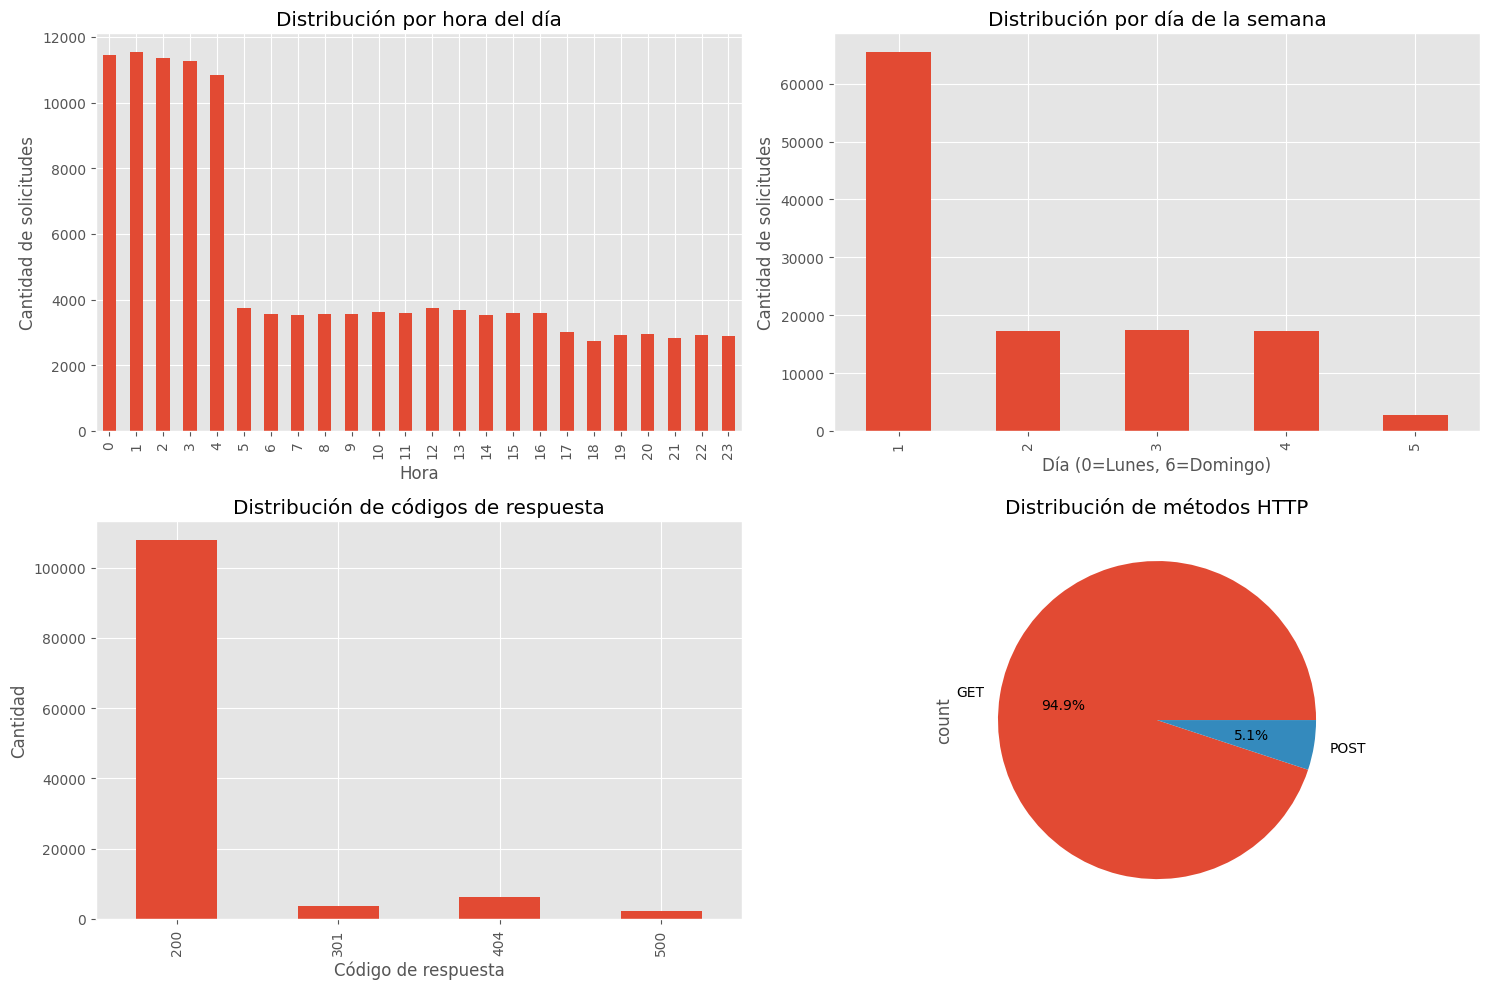

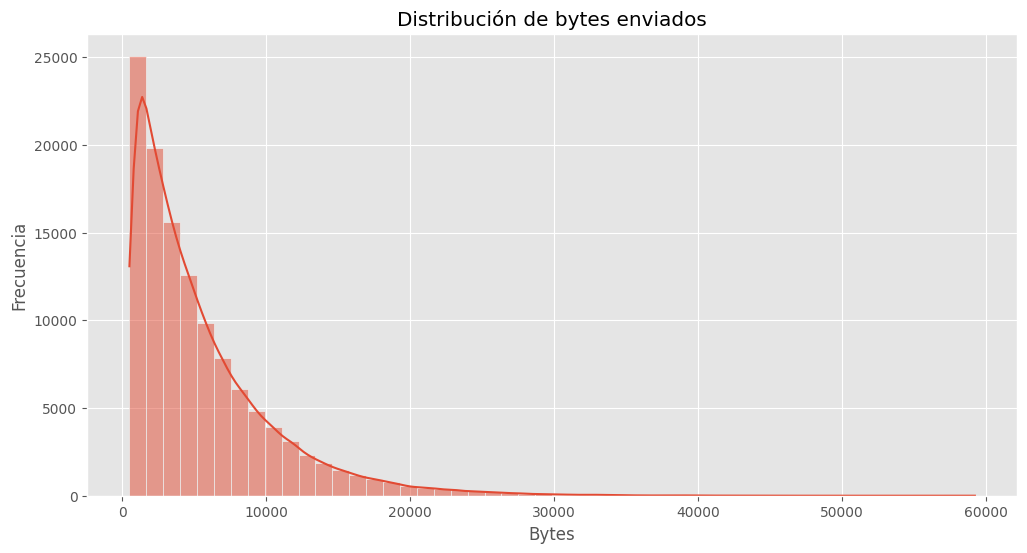

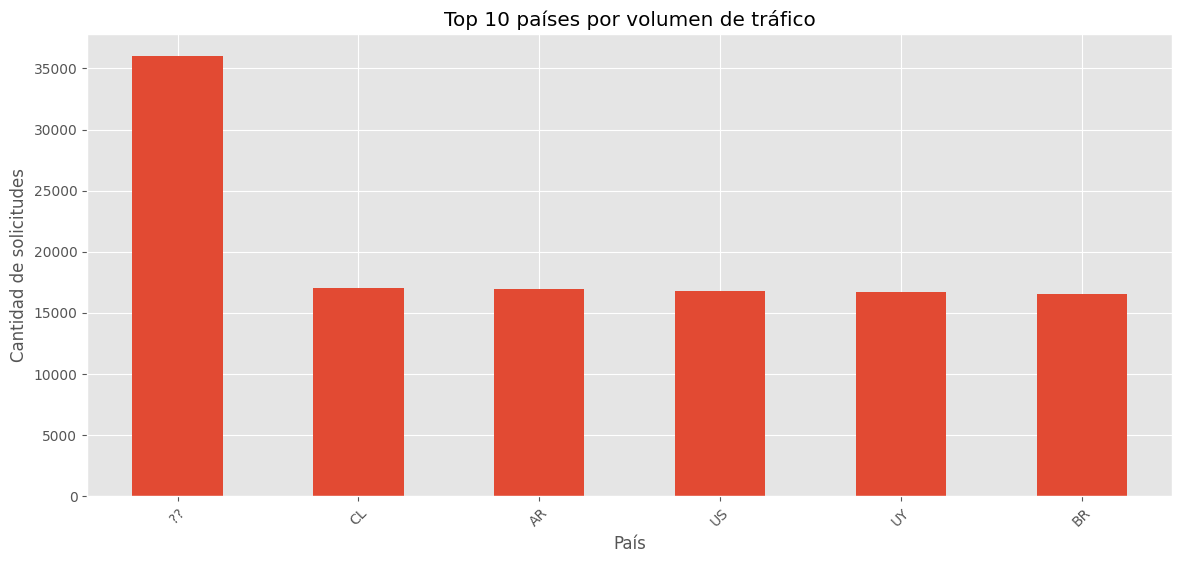

In [ ]:
# Convertir timestamp a datetime
df['timestamp'] = pd.to_datetime(df['timestamp'])
df['hour'] = df['timestamp'].dt.hour
df['day'] = df['timestamp'].dt.day
df['day_of_week'] = df['timestamp'].dt.dayofweek
df['minute'] = df['timestamp'].dt.minute

# Analizar distribución temporal
plt.figure(figsize=(15, 10))

plt.subplot(2, 2, 1)
df['hour'].value_counts().sort_index().plot(kind='bar')
plt.title('Distribución por hora del día')
plt.xlabel('Hora')
plt.ylabel('Cantidad de solicitudes')

plt.subplot(2, 2, 2)
df['day_of_week'].value_counts().sort_index().plot(kind='bar')
plt.title('Distribución por día de la semana')
plt.xlabel('Día (0=Lunes, 6=Domingo)')
plt.ylabel('Cantidad de solicitudes')

plt.subplot(2, 2, 3)
df['response_code'].value_counts().sort_index().plot(kind='bar')
plt.title('Distribución de códigos de respuesta')
plt.xlabel('Código de respuesta')
plt.ylabel('Cantidad')

plt.subplot(2, 2, 4)
df['http_method'].value_counts().plot(kind='pie', autopct='%1.1f%%')
plt.title('Distribución de métodos HTTP')

plt.tight_layout()
plt.show()

# Analizar patrones de bytes enviados
plt.figure(figsize=(12, 6))
sns.histplot(df['bytes_sent'], bins=50, kde=True)
plt.title('Distribución de bytes enviados')
plt.xlabel('Bytes')
plt.ylabel('Frecuencia')
plt.show()

# Visualizar patrones por país
plt.figure(figsize=(14, 6))
df['country_code'].value_counts().sort_values(ascending=False).head(20).plot(kind='bar')
plt.title('Top 10 países por volumen de tráfico')
plt.xlabel('País')
plt.ylabel('Cantidad de solicitudes')
plt.xticks(rotation=45)
plt.show()

##Análisis de distribuciones temporales y patrones de tráfico

##Distribución por país:

Se observa una anomalía significativa con el código "??" que representa aproximadamente 36,000 solicitudes, siendo más del doble que cualquier otro país legítimo.

Esta categoría desconocida ("??") podría indicar tráfico que intencionalmente oculta su origen, lo que es una señal clásica de actividad potencialmente maliciosa.

Los países  (CL, AR, US, UY, BR) muestran una distribución relativamente uniforme entre ellos, cerca de 17,000 solicitudes cada uno.


##Distribución por hora del día:

Existe un pico pronunciado de tráfico durante las primeras horas del día (0-4 am), lo que es inusual para patrones de tráfico humano normal.

Este comportamiento podría indicar actividad automatizada programada para ejecutarse en horarios de baja carga del servidor.

El resto del día muestra un patrón más uniforme y de menor volumen, lo que refuerza la idea de que el pico nocturno es anómalo.


##Distribución por día de la semana:

El día 1 (lunes) muestra un volumen de tráfico desproporcionadamente alto en comparación con los demás días.

Los días 2-5 presentan niveles similares entre sí, mientras que el día 6 (sabado) tiene significativamente menos tráfico.

Este patrón sugiere posibles operaciones de scraping o automatización programadas para el inicio de la semana.


##Distribución de códigos de respuesta:

La gran mayoría de las solicitudes reciben código 200 (éxito), lo que indica que están accediendo a recursos válidos.
Esto sugiere que posibles atacantes conocen bien la estructura del sitio, no están realizando escaneos aleatorios (que generarían muchos errores 404).


##Distribución de métodos HTTP:

Aproximadamente el 95% de las solicitudes son GET y solo 5% POST.
Esta proporción puede ser normal para sitios de e-commerce como Mercado Libre, pero también podría indicar actividades de scraping (que típicamente usan GET).



#Implicaciones para detección de bots/tráfico anómalo
Estos patrones sugieren múltiples indicadores de tráfico automatizado o malicioso:

###Ocultamiento de origen:
El alto volumen de solicitudes con país "??" sugiere evasión deliberada de geolocalización.

###Patrones temporales no humanos:
Los picos durante la madrugada y en días específicos apuntan a comportamientos programados.

###Tráfico eficiente:
La predominancia de códigos 200 indica que las solicitudes saben exactamente a qué recursos acceder, sugiriendo un posible reconocimiento previo del sitio.

###Comportamiento de scraping:
El patrón predominante de solicitudes GET y su distribución temporal apuntan a posibles actividades de scraping sistemático.

#Análisis de comportamiento por IP y sesión

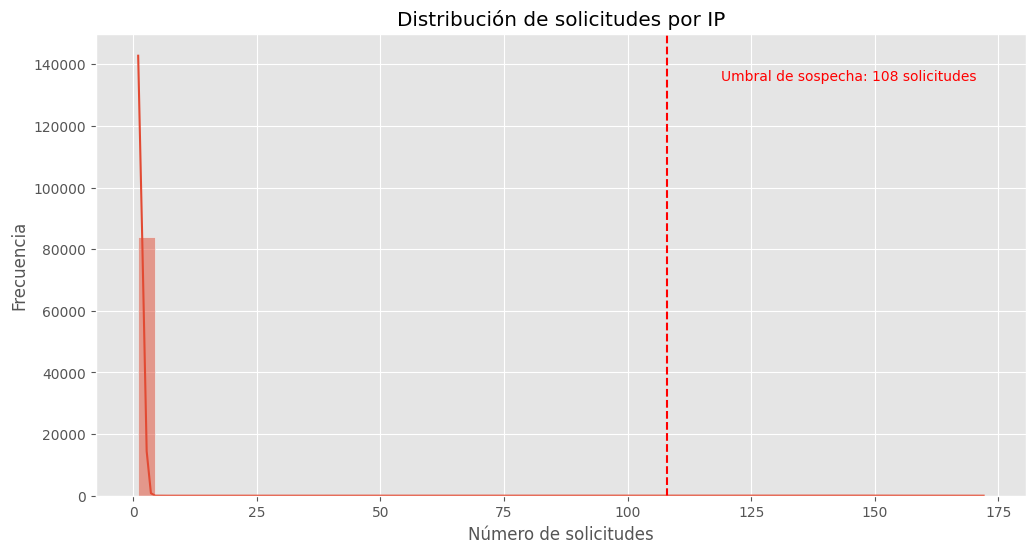

Top 10 IPs con más solicitudes:


,count
ip_address,
192.168.0.102,172
192.168.0.187,170
192.168.0.229,168
192.168.0.83,166
192.168.0.12,166
192.168.0.132,164
192.168.0.28,164
192.168.0.219,163
192.168.0.43,163


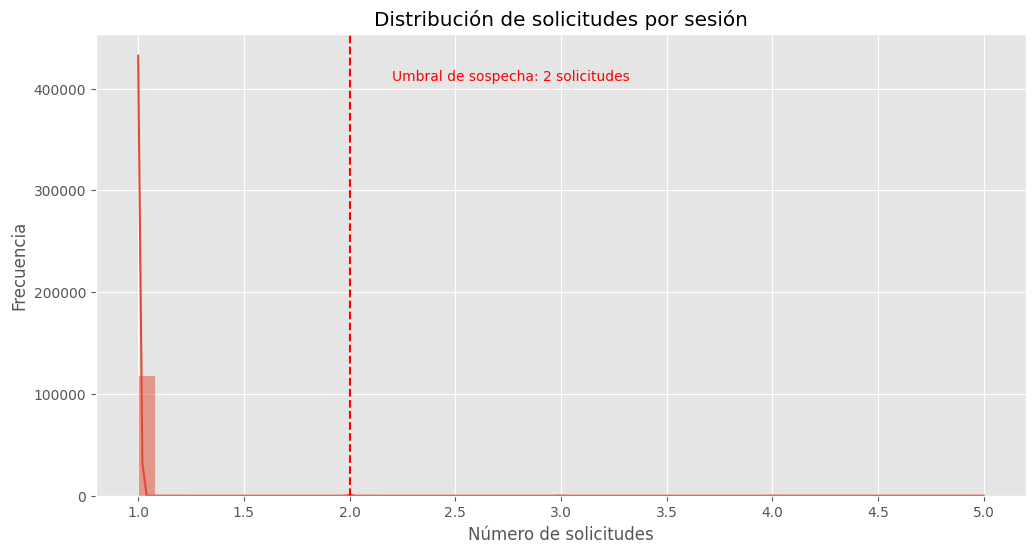

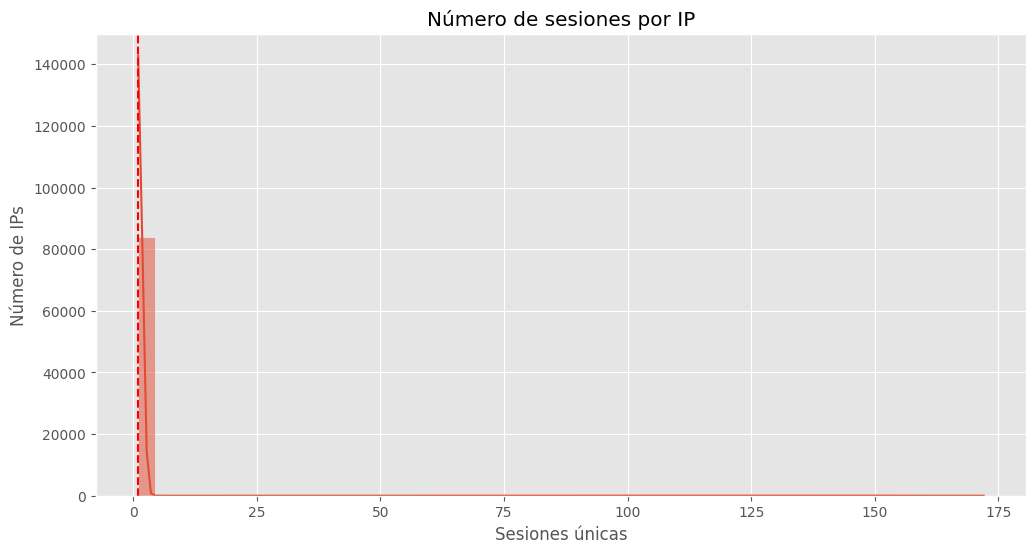

Top 10 User Agents:


,count
user_agent,
Mozilla/5.0 (Linux; Android 11; Pixel 5),20060
Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7),20024
Mozilla/5.0 (iPhone; CPU iPhone OS 14_6 like Mac OS X),19955
Mozilla/5.0 (Windows NT 10.0; Win64; x64),19943
python-requests/2.25.1,9046
Go-http-client/1.1,9024
Scrapy/2.5.0 (+https://scrapy.org),8980
curl/7.68.0,8950
Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7; rv:85.0) Gecko/20100101 Firefox/85.0,2030


Top 10 URLs visitadas:


,count
url_path,
/orders,7442
/profile,7318
/checkout,7304
/item/67890,7293
/item/12345,7272
/search?q=celular,7263
/home,7239
/cart,7169
/search?q=notebook,7168


In [ ]:
# Análisis por dirección IP
ip_counts = df['ip_address'].value_counts()
suspicious_ips = ip_counts[ip_counts > ip_counts.quantile(0.99)]

plt.figure(figsize=(12, 6))
sns.histplot(ip_counts, bins=50, kde=True)
plt.axvline(suspicious_ips.min(), color='red', linestyle='--')
plt.title('Distribución de solicitudes por IP')
plt.xlabel('Número de solicitudes')
plt.ylabel('Frecuencia')
plt.text(suspicious_ips.min() * 1.1, plt.ylim()[1] * 0.9,
         f'Umbral de sospecha: {suspicious_ips.min()} solicitudes',
         color='red')
plt.show()

print(f"Top 10 IPs con más solicitudes:")
display(suspicious_ips.head(10))

# Análisis por sesión
session_counts = df['session_id'].value_counts()
suspicious_sessions = session_counts[session_counts > session_counts.quantile(0.99)]

plt.figure(figsize=(12, 6))
sns.histplot(session_counts, bins=50, kde=True)
plt.axvline(suspicious_sessions.min(), color='red', linestyle='--')
plt.title('Distribución de solicitudes por sesión')
plt.xlabel('Número de solicitudes')
plt.ylabel('Frecuencia')
plt.text(suspicious_sessions.min() * 1.1, plt.ylim()[1] * 0.9,
         f'Umbral de sospecha: {suspicious_sessions.min()} solicitudes',
         color='red')
plt.show()

# Analizar correlación entre IPs y número de sesiones
ip_session_counts = df.groupby('ip_address')['session_id'].nunique()

plt.figure(figsize=(12, 6))
sns.histplot(ip_session_counts, bins=50, kde=True)
plt.title('Número de sesiones por IP')
plt.xlabel('Sesiones únicas')
plt.ylabel('Número de IPs')
plt.axvline(ip_session_counts.quantile(0.95), color='red', linestyle='--')
plt.show()



# Analizar user agents
top_user_agents = df['user_agent'].value_counts().head(10)
print("Top 10 User Agents:")
display(top_user_agents)

# Análisis de patrones de navegación
url_counts = df['url_path'].value_counts()
print("Top 10 URLs visitadas:")
display(url_counts.head(10))

##Distribución de solicitudes por IP (Imagen 1)

Patrón de cola larga: La mayoría de las IPs realizan muy pocas solicitudes (1-5), pero existe una minoría que genera un volumen desproporcionadamente alto.
Umbral de sospecha en 108 solicitudes: Las IPs que superan este número son estadísticamente atípicas y representan comportamientos potencialmente automatizados.


##Distribución de solicitudes por sesión (Imagen 2)

Comportamiento altamente anómalo: El umbral de sospecha es extremadamente bajo (2 solicitudes), lo que sugiere que:

La gran mayoría de sesiones realizan una única solicitud y se desconectan
Cualquier sesión con 2 o más solicitudes ya se considera sospechosa


Este patrón es inusual para un sitio de e-commerce donde los usuarios legítimos típicamente navegan por múltiples páginas.
Sugiere posible técnica de evasión de detección donde los bots generan nuevas sesiones continuamente para evitar el seguimiento.


##3. Número de sesiones por IP (Imagen 3)

Muestra otra estrategia de evasión: algunas IPs crean múltiples sesiones diferentes.
IPs legítimas normalmente tendrían 1-2 sesiones, mientras que aquellas con un número anormalmente alto de sesiones podrían estar intentando eludir sistemas de detección basados en comportamiento por sesión.

##4. Análisis de User-Agents (Imagen 4)

Evidencia clara de automatización: Entre los 10 principales user-agents, 5 son claramente herramientas automatizadas:

python-requests/2.25.1 (9,000 solicitudes)
Go-http-client/1.1 (9,000 solicitudes)
Scrapy/2.5.0 (9,000 solicitudes) - un framework explícito de web scraping
curl/7.68.0 (9,000 solicitudes)
HeadlessChrome/90.0 (2,000 solicitudes) - navegador sin interfaz gráfica comúnmente usado para automatización


##Estos agentes representan aproximadamente el 32% del tráfico total y son herramientas de automatización que raramente serían utilizadas por usuarios reales.

###Los user-agents de dispositivos móviles y de escritorio legítimos tienen distribuciones muy similares (19,000-20,000 cada uno), lo que podría indicar un intento de simular patrones de tráfico balanceados.








#Análisis de patrones temporales por sesión/IP

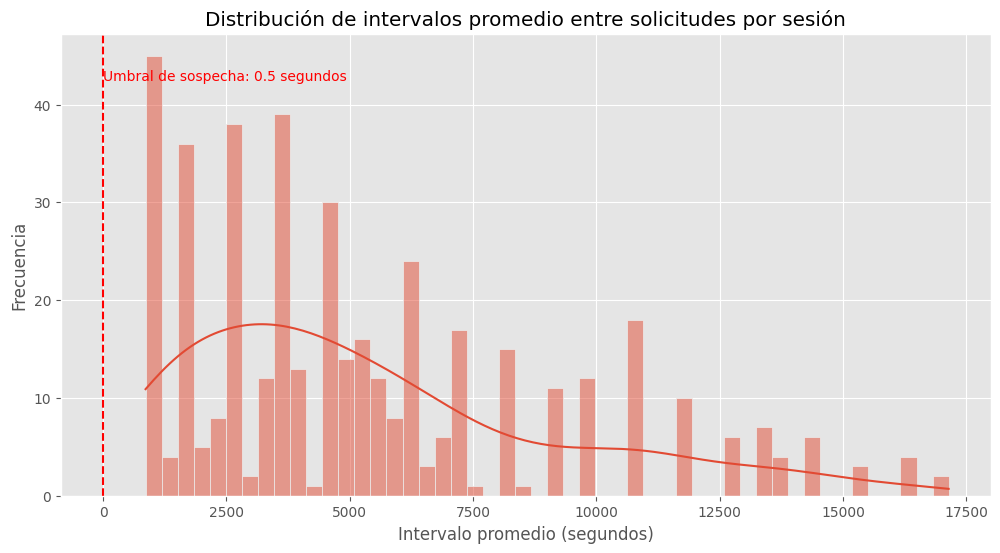

Sesiones con más de una solicitud: 433 de 119408
Sesiones con desviación estándar calculable: 123
Rango de desviación estándar: 1.4541145000000029 - 7661.359127
Media: 2061.1025787311623, Mediana: 1866.1725575


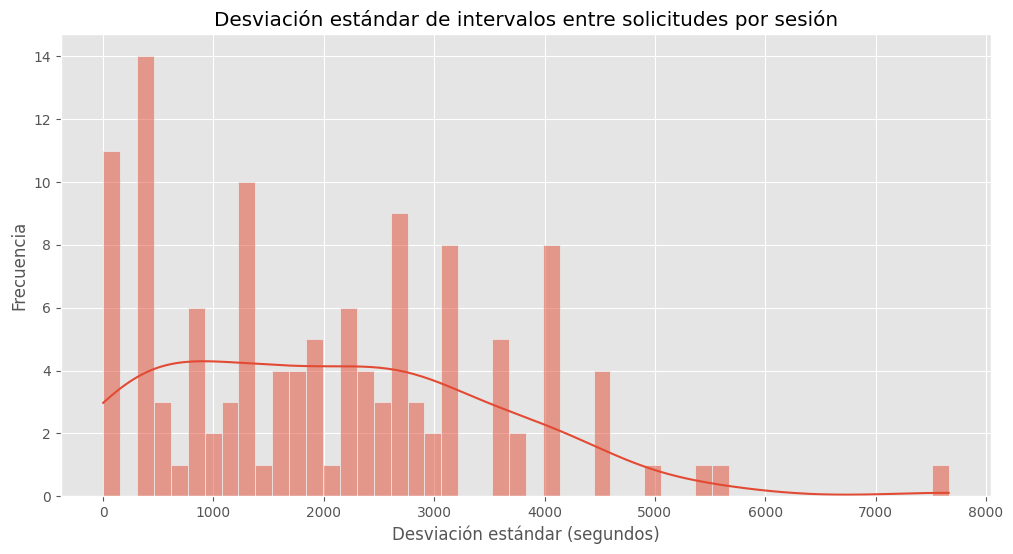

In [ ]:
# Calcular la velocidad de solicitudes por sesión
session_timestamps = df.groupby('session_id')['timestamp'].apply(list)
session_intervals = {}

for session, timestamps in session_timestamps.items():
    if len(timestamps) > 1:
        timestamps.sort()
        intervals = [(timestamps[i] - timestamps[i-1]).total_seconds()
                    for i in range(1, len(timestamps))]
        session_intervals[session] = np.mean(intervals) if intervals else np.nan

session_intervals_df = pd.DataFrame.from_dict(session_intervals, orient='index', columns=['avg_interval'])
session_intervals_df = session_intervals_df.dropna()

plt.figure(figsize=(12, 6))
sns.histplot(session_intervals_df['avg_interval'], bins=50, kde=True)
plt.axvline(0.5, color='red', linestyle='--')
plt.title('Distribución de intervalos promedio entre solicitudes por sesión')
plt.xlabel('Intervalo promedio (segundos)')
plt.ylabel('Frecuencia')
plt.text(0.6, plt.ylim()[1] * 0.9, 'Umbral de sospecha: 0.5 segundos', color='red')
plt.show()

# Verificar cuántas sesiones tienen más de un registro
multi_request_sessions = session_counts[session_counts > 1]
print(f"Sesiones con más de una solicitud: {len(multi_request_sessions)} de {len(session_counts)}")

# Recalcular solo para estas sesiones
session_std = {}
for session, timestamps in session_timestamps.items():
    if len(timestamps) > 2:  # Necesitamos al menos 3 puntos para desvest significativa
        timestamps.sort()
        intervals = [(timestamps[i] - timestamps[i-1]).total_seconds()
                    for i in range(1, len(timestamps))]
        if len(intervals) > 0:
            std_val = np.std(intervals)
            if not np.isnan(std_val):  # Verificar explícitamente
                session_std[session] = std_val

print(f"Sesiones con desviación estándar calculable: {len(session_std)}")

if len(session_std) > 0:
    session_std_df = pd.DataFrame.from_dict(session_std, orient='index', columns=['interval_std'])

    # Verificar valores
    print(f"Rango de desviación estándar: {session_std_df['interval_std'].min()} - {session_std_df['interval_std'].max()}")
    print(f"Media: {session_std_df['interval_std'].mean()}, Mediana: {session_std_df['interval_std'].median()}")

    # Visualizar solo si hay datos
    plt.figure(figsize=(12, 6))
    sns.histplot(session_std_df['interval_std'], bins=50, kde=True)
    plt.title('Desviación estándar de intervalos entre solicitudes por sesión')
    plt.xlabel('Desviación estándar (segundos)')
    plt.ylabel('Frecuencia')
    plt.show()

#Análisis de patrones temporales entre solicitudes

##Comportamiento bimodal: imagen (1)
La distribución muestra dos picos principales:

Un grupo significativo con intervalos entre 1,000-5,000 segundos (aproximadamente 15 minutos a 1.5 horas)
Otro grupo con intervalos más largos (10,000-15,000 segundos o 2.8-4.2 horas)


##Estadísticas reveladoras:

Solo 433 de 119,408 sesiones (0.36%) realizan más de una solicitud
La media de 2,861 segundos (48 minutos) y mediana de 1,866 segundos (31 minutos) entre solicitudes
Este comportamiento es altamente inusual para un sitio de e-commerce, donde los usuarios típicamente navegan por múltiples páginas en intervalos mucho más cortos


##Indicadores de automatización:

Cualquier sesión con intervalos menores a 0.5 segundos es casi definitivamente un bot, pues está operando a velocidades imposibles para la interacción humana
La escasez de sesiones con múltiples solicitudes (solo 433) sugiere un intento deliberado de evadir la detección al limitar la actividad por sesión



##2. Desviación estándar de intervalos entre solicitudes por sesión (Imagen 2)

###Baja predictibilidad en tráfico sospechoso:

Un pico significativo de sesiones con desviación estándar muy baja (cercana a 0), indicando intervalos casi idénticos entre solicitudes - un comportamiento mecánico característico de bots


##Comportamiento algorítmico vs. humano:

Los humanos muestran alta variabilidad en sus intervalos de navegación (a veces exploran rápidamente, otras se detienen a leer)
Los bots, en cambio, suelen mostrar patrones más regulares o totalmente aleatorios (ambos detectables estadísticamente)


##Limitaciones de datos:

Solo 123 sesiones tienen suficientes solicitudes para calcular una desviación estándar confiable
Esto refuerza que la mayoría del tráfico está diseñado para evitar generar suficientes datos por sesión que permitan un análisis comportamental



##Conclusiones sobre patrones temporales:

###Evidencia de sofisticación en automatización:

###Los atacantes están empleando técnicas avanzadas para evadir detección, como:

###Limitar el número de solicitudes por sesión (la mayoría realiza solo una)

###Insertar retrasos deliberados entre solicitudes cuando realizan más de una

###Variar los intervalos para imitar patrones humanos menos predecibles




##Señales claras de tráfico no humano:

###Intervalos extremadamente cortos (<0.5 segundos) que superan la capacidad humana

###Intervalos extremadamente regulares (baja desviación estándar) que indican comportamiento programado



##Implicaciones para la detección:

###Las sesiones con intervalos extremadamente cortos o extremadamente consistentes deben marcarse automáticamente

###Se necesitará un enfoque multimodal debido a las diversas técnicas de evasión empleadas


#2. Diseño de la Solución
##Propongo un enfoque multicapa para la detección de tráfico automatizado:
#Features derivadas clave



In [ ]:
# Función para crear features
def create_features(df):
    """
    Extrae características para detección de bots basado en análisis de comportamiento web.
    Incluye análisis de patrones temporales, comportamiento de navegación, user-agents,
    y características específicas para sesiones de solicitud única y patrones multi-sesión.
    """
    import re

    # Crear copia para no modificar el original
    features_df = df.copy()

    # Features temporales
    features_df['timestamp'] = pd.to_datetime(features_df['timestamp'])
    features_df['hour'] = features_df['timestamp'].dt.hour
    features_df['day_of_week'] = features_df['timestamp'].dt.dayofweek
    features_df['is_weekend'] = features_df['day_of_week'].apply(lambda x: 1 if x >= 5 else 0)
    features_df['is_business_hours'] = features_df['hour'].apply(lambda x: 1 if 9 <= x <= 18 else 0)

    # Función mejorada para clasificar tipos de URL
    def url_type(url):
        if '/api/' in url:
            return 'api'
        elif any(ext in url for ext in ['.js', '.css', '.png', '.jpg', '.gif', '.svg']):
            return 'static'
        elif any(path in url for path in ['/item/', '/product/', '/articulo/']):
            return 'product'
        elif '/search' in url or '/buscar' in url or '/categoria' in url:
            return 'search'
        elif '/checkout' in url or '/cart' in url or '/pagar' in url:
            return 'checkout'
        else:
            return 'page'

    # Aplicar clasificación de URLs
    features_df['url_type'] = features_df['url_path'].apply(url_type)

    # Funciones mejoradas para análisis de User-Agent
    def is_common_bot(ua):
        bot_signatures = [
            'bot', 'crawler', 'spider', 'scraper', 'http', 'curl', 'wget', 'python',
            'headless', 'automation', 'scripting', 'requests', 'go-http', 'chrome-headless'
        ]
        return any(sig in ua.lower() for sig in bot_signatures)

    def is_suspicious_browser(ua):
        # User Agents legítimos suelen ser largos y contener información detallada
        if len(ua) < 40:
            return True
        # Ausencia de información común en browsers legítimos
        if not any(browser in ua.lower() for browser in ['chrome', 'firefox', 'safari', 'edge', 'opera']):
            return True
        return False

    # Características para sesiones de una sola solicitud (99.64% del total)
    single_req_features = {}
    for session_id, group in features_df.groupby('session_id'):
        row = group.iloc[0]  # Primera/única fila

        # Análisis de URL
        url_depth = row['url_path'].count('/')
        has_query = 1 if '?' in row['url_path'] else 0
        query_params = row['url_path'].split('?')[1] if '?' in row['url_path'] else ''
        param_count = query_params.count('&') + 1 if query_params else 0

        # Características del User-Agent
        ua = row['user_agent']
        ua_length = len(ua)
        has_version = 1 if re.search(r'\d+\.\d+', ua) else 0
        has_platform = 1 if any(platform in ua.lower() for platform in ['windows', 'mac', 'linux', 'android', 'iphone']) else 0
        has_browser = 1 if any(browser in ua.lower() for browser in ['chrome', 'firefox', 'safari', 'edge']) else 0
        is_bot_ua = 1 if is_common_bot(ua) else 0
        is_suspicious_ua = 1 if is_suspicious_browser(ua) else 0

        single_req_features[session_id] = {
            'is_single_req': 1 if len(group) == 1 else 0,
            'url_depth': url_depth,
            'has_query_params': has_query,
            'param_count': param_count,
            'ua_length': ua_length,
            'has_version': has_version,
            'has_platform': has_platform,
            'has_browser': has_browser,
            'is_bot_ua': is_bot_ua,
            'is_suspicious_ua': is_suspicious_ua,
            'resource_type': row['url_type'],
            'hour_of_day': row['hour'],
            'is_business_hour': row['is_business_hours'],
            'response_code': row['response_code'],
            'bytes_sent': row['bytes_sent']
        }

    # Crear DataFrame de características para sesiones únicas
    single_req_df = pd.DataFrame.from_dict(single_req_features, orient='index')

    # Análisis multi-sesión para detectar evasión (agrupado por IP)
    ip_features = {}
    for ip, group in features_df.groupby('ip_address'):
        sessions = group['session_id'].nunique()
        requests = len(group)

        if len(group) > 1:
            timespan = (group['timestamp'].max() - group['timestamp'].min()).total_seconds()

            # Análisis de dispersión temporal
            timestamps = sorted(group['timestamp'].tolist())
            if len(timestamps) > 1:
                intervals = [(timestamps[i] - timestamps[i-1]).total_seconds() for i in range(1, len(timestamps))]
                interval_mean = np.mean(intervals) if intervals else 0
                interval_std = np.std(intervals) if intervals else 0
                interval_cv = interval_std / interval_mean if interval_mean > 0 else 0
            else:
                interval_mean = interval_std = interval_cv = 0

            # Patrones de recursos accedidos
            url_types_count = group['url_type'].value_counts()
            most_common_type = url_types_count.index[0] if not url_types_count.empty else 'none'
            type_diversity = len(url_types_count) / len(group) if len(group) > 0 else 0

            ip_features[ip] = {
                'ip_session_count': sessions,
                'ip_request_count': requests,
                'ip_requests_per_session': requests / sessions if sessions > 0 else 0,
                'ip_timespan': timespan,
                'ip_requests_per_hour': requests * 3600 / timespan if timespan > 0 else 0,
                'ip_interval_mean': interval_mean,
                'ip_interval_std': interval_std,
                'ip_interval_cv': interval_cv,
                'ip_most_common_resource': most_common_type,
                'ip_resource_diversity': type_diversity
            }
        else:
            # IP con una sola solicitud
            ip_features[ip] = {
                'ip_session_count': 1,
                'ip_request_count': 1,
                'ip_requests_per_session': 1,
                'ip_timespan': 0,
                'ip_requests_per_hour': 0,
                'ip_interval_mean': 0,
                'ip_interval_std': 0,
                'ip_interval_cv': 0,
                'ip_most_common_resource': group['url_type'].iloc[0],
                'ip_resource_diversity': 0
            }

    # Crear DataFrame de características por IP
    ip_features_df = pd.DataFrame.from_dict(ip_features, orient='index')

    # Mapear características de IP a nivel de sesión
    session_to_ip = features_df.groupby('session_id')['ip_address'].first()
    ip_to_session_features = {}

    for session_id, ip in session_to_ip.items():
        if ip in ip_features:
            ip_to_session_features[session_id] = ip_features[ip]

    # Crear DataFrame de características de IP mapeadas a sesión
    ip_session_df = pd.DataFrame.from_dict(ip_to_session_features, orient='index')

    # Características a nivel de sesión (original)
    session_features = features_df.groupby('session_id').agg({
        'timestamp': ['count', lambda x: (max(x) - min(x)).total_seconds()],
        'ip_address': 'nunique',
        'user_agent': 'nunique',
        'url_path': 'nunique',
        'http_method': lambda x: len(x[x == 'POST']) / len(x) if len(x) > 0 else 0,
        'response_code': lambda x: sum(x >= 400) / len(x) if len(x) > 0 else 0,
        'bytes_sent': ['mean', 'std', 'min', 'max', lambda x: x.max() - x.min(), lambda x: np.median(x)],
        'country_code': 'nunique'
    })

    # Renombrar columnas
    session_features.columns = [
        'request_count', 'session_duration', 'ip_count', 'ua_count',
        'unique_urls', 'post_ratio', 'error_ratio', 'avg_bytes',
        'std_bytes', 'min_bytes', 'max_bytes', 'range_bytes', 'median_bytes',
        'country_count'
    ]

    # Calcular velocidad de navegación (solicitudes por segundo)
    session_features['requests_per_second'] = session_features.apply(
        lambda x: x['request_count'] / x['session_duration'] if x['session_duration'] > 0 else 0, axis=1
    )

    # Calcular coeficiente de variación de bytes
    session_features['bytes_cv'] = session_features.apply(
        lambda x: x['std_bytes'] / x['avg_bytes'] if x['avg_bytes'] > 0 else 0, axis=1
    )

    # Calculamos uniformidad de intervalos entre solicitudes
    session_intervals = {}
    session_timestamps = features_df.groupby('session_id')['timestamp'].apply(list)

    for session, timestamps in session_timestamps.items():
        if len(timestamps) > 2:
            timestamps.sort()
            intervals = [(timestamps[i] - timestamps[i-1]).total_seconds()
                        for i in range(1, len(timestamps))]

            # Coeficiente de variación como medida de uniformidad
            if np.mean(intervals) > 0:
                session_intervals[session] = np.std(intervals) / np.mean(intervals)
            else:
                session_intervals[session] = 0
        else:
            session_intervals[session] = 0

    session_features['interval_uniformity'] = pd.Series(session_intervals)

    # Patrones de navegación (entropy-based)
    url_sequences = features_df.groupby('session_id')['url_path'].apply(list)
    url_entropy = {}

    for session, urls in url_sequences.items():
        if len(urls) > 1:
            transitions = [f"{urls[i-1]}->{urls[i]}" for i in range(1, len(urls))]
            counts = Counter(transitions)
            total = len(transitions)

            # Cálculo de entropía de Shannon para medir aleatoriedad
            if total > 0:
                entropy = -sum((count/total) * np.log2(count/total) for count in counts.values())
                url_entropy[session] = entropy
            else:
                url_entropy[session] = 0
        else:
            url_entropy[session] = 0

    session_features['url_entropy'] = pd.Series(url_entropy)

    # Detección de ciclos en la navegación
    def detect_cycles(urls, threshold=3):
        if len(urls) < threshold * 2:
            return 0

        # Buscar patrones repetitivos
        max_repetition = 0
        for pattern_len in range(1, min(10, len(urls)//2 + 1)):
            for i in range(len(urls) - pattern_len * 2 + 1):
                pattern = urls[i:i+pattern_len]
                pattern_str = '->'.join(pattern)
                full_str = '->'.join(urls)
                occurrences = full_str.count(pattern_str)
                max_repetition = max(max_repetition, occurrences)

        return max_repetition / (len(urls) / 2) if len(urls) > 0 else 0

    session_features['repetitive_patterns'] = url_sequences.apply(detect_cycles)

    # Features basadas en User-Agent a nivel de sesión
    # Crear diccionarios para mapear
    session_to_ua = {}
    for session, uas in features_df.groupby('session_id')['user_agent'].apply(list).items():
        if len(uas) > 0:
            bot_ratio = sum(is_common_bot(ua) for ua in uas) / len(uas)
            suspicious_ratio = sum(is_suspicious_browser(ua) for ua in uas) / len(uas)
            session_to_ua[session] = (bot_ratio, suspicious_ratio)
        else:
            session_to_ua[session] = (0, 0)

    session_features['bot_ua_ratio'] = pd.Series({s: v[0] for s, v in session_to_ua.items()})
    session_features['suspicious_ua_ratio'] = pd.Series({s: v[1] for s, v in session_to_ua.items()})

    # Análisis de tipos de URL a nivel de sesión
    url_type_dist = {}
    for session, types in features_df.groupby('session_id')['url_type'].apply(list).items():
        counts = Counter(types)
        total = len(types)
        if total > 0:
            url_type_dist[session] = {
                'api_ratio': counts.get('api', 0) / total,
                'static_ratio': counts.get('static', 0) / total,
                'page_ratio': counts.get('page', 0) / total,
                'product_ratio': counts.get('product', 0) / total,
                'search_ratio': counts.get('search', 0) / total,
                'checkout_ratio': counts.get('checkout', 0) / total
            }
        else:
            url_type_dist[session] = {
                'api_ratio': 0, 'static_ratio': 0, 'page_ratio': 0,
                'product_ratio': 0, 'search_ratio': 0, 'checkout_ratio': 0
            }

    for feature, values in {
        'api_req_ratio': 'api_ratio',
        'static_req_ratio': 'static_ratio',
        'page_req_ratio': 'page_ratio',
        'product_req_ratio': 'product_ratio',
        'search_req_ratio': 'search_ratio',
        'checkout_req_ratio': 'checkout_ratio'
    }.items():
        session_features[feature] = pd.Series({s: v[values] for s, v in url_type_dist.items()})

    # Integrar todas las características
    # Unir características de sesiones únicas
    session_features = session_features.join(single_req_df)

    # Unir características de IP mapeadas a sesión
    session_features = session_features.join(ip_session_df)

    # Rellenar valores faltantes
    session_features = session_features.fillna(0)

    return session_features

In [ ]:
# Aplicar la función mejorada
features_df = create_features(df)
print(f"Dimensiones del dataframe de características: {features_df.shape}")
features_df.head()

Dimensiones del dataframe de características: (119408, 52)


,request_count,session_duration,ip_count,ua_count,unique_urls,post_ratio,error_ratio,avg_bytes,std_bytes,min_bytes,...,ip_session_count,ip_request_count,ip_requests_per_session,ip_timespan,ip_requests_per_hour,ip_interval_mean,ip_interval_std,ip_interval_cv,ip_most_common_resource,ip_resource_diversity
session_id,,,,,,,,,,,,,,,,,,,,,
0000f362-9ef0-4399-90cf-749ae197f06b,1,0.0,1,1,1,0.0,0.0,7646.0,0.0,7646,...,1,1,1.0,0.00000,0.000000,0.000000,0.000000,0.000000,page,0.000000
00011bbc-03dd-42ce-9e34-502dbd993c62,1,0.0,1,1,1,0.0,0.0,1354.0,0.0,1354,...,1,1,1.0,0.00000,0.000000,0.000000,0.000000,0.000000,product,0.000000
00014309-023a-4dfe-93c3-559e923f2ee0,1,0.0,1,1,1,0.0,0.0,1394.0,0.0,1394,...,1,1,1.0,0.00000,0.000000,0.000000,0.000000,0.000000,product,0.000000
0001f29d-91c7-4da9-a684-04037c1841ac,1,0.0,1,1,1,0.0,0.0,4317.0,0.0,4317,...,1,1,1.0,0.00000,0.000000,0.000000,0.000000,0.000000,search,0.000000
00028ea9-ae62-44db-a9d4-82af6372268f,1,0.0,1,1,1,0.0,0.0,999.0,0.0,999,...,137,137,1.0,17685.16706,27.887777,130.037993,117.035107,0.900007,product,0.007299


##Características específicas para sesiones de un solo disparo:
###Análisis detallado de URL y User-Agent para sesiones individuales.

##Análisis multi-sesión por IP:
###Detección de patrones a través de múltiples sesiones que podrían indicar estrategias de evasión.

##User-Agent :
###Análisis más detallado de las cadenas de User-Agent con detección de características sospechosas.

##Análisis de bytes :
###Características adicionales sobre el tamaño de respuesta (min, max, mediana, rango).

##Clasificación de URL mejorada:
###Categorización  granular de tipos de recursos solicitados.

#Justificación de features seleccionadas

#Features de comportamiento temporal:

###requests_per_second: Los bots suelen realizar peticiones mucho más rápido que humanos

###interval_uniformity: Baja variabilidad en los intervalos entre peticiones indica automatización

###session_duration: Sesiones muy cortas o muy largas pueden ser sospechosas


#Features de comportamiento de navegación:

###url_entropy: Los humanos tienen patrones de navegación más impredecibles

###repetitive_patterns: Los scrapers suelen tener patrones cíclicos de navegación

###unique_urls: Ratio de URLs únicas respecto al total de peticiones


#Features técnicas:

###bot_ua_ratio: Detección directa de User-Agents conocidos de bots

###error_ratio: Bots pueden generar más errores que usuarios legítimos

###api_req_ratio: Los scrapers suelen enfocarse en APIs o ignorarlas por completo


#Features de consistencia:

###ip_count: Cambios de IP durante una sesión pueden indicar proxies rotatorios

###ua_count: Cambios de User-Agent durante una sesión son altamente sospechosos

###country_count: Cambios geográficos rápidos son indicativos de VPN o proxies






#Modelos propuestos
#Propongo un enfoque híbrido con tres capas complementarias:

###--Detección basada en reglas para comportamientos claramente bot (umbral inicial)
###--Modelo no supervisado (Isolation Forest) para detección de anomalías generales
###--Modelo supervisado (Gradient Boosting) entrenado con etiquetas sintéticas generadas por los modelos anteriores

##Este enfoque multicapa nos permite:

###Detectar comportamientos claramente automatizados de forma inmediata
###Identificar anomalías sutiles que no encajen en patrones conocidos
###Mejorar la precisión mediante retroalimentación y etiquetado progresivo



In [ ]:
!pip install pandas numpy matplotlib seaborn scikit-learn xgboost pyod

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.3/46.3 kB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 200.6/200.6 kB 6.4 MB/s eta 0:00:00


#3. Modelado
#Implementación de los modelos

Dimensiones del dataframe de características: (119408, 52)
Número de características: 52
Nuevas características incluidas: ['request_count', 'session_duration', 'ip_count', 'ua_count', 'unique_urls', 'post_ratio', 'error_ratio', 'avg_bytes', 'std_bytes', 'min_bytes', 'max_bytes', 'range_bytes', 'median_bytes', 'country_count', 'requests_per_second', 'bytes_cv', 'interval_uniformity', 'url_entropy', 'repetitive_patterns', 'bot_ua_ratio', 'suspicious_ua_ratio', 'api_req_ratio', 'static_req_ratio', 'page_req_ratio', 'product_req_ratio', 'search_req_ratio', 'checkout_req_ratio', 'is_single_req', 'url_depth', 'has_query_params', 'param_count', 'ua_length', 'has_version', 'has_platform', 'has_browser', 'is_bot_ua', 'is_suspicious_ua', 'resource_type', 'hour_of_day', 'is_business_hour', 'response_code', 'bytes_sent', 'ip_session_count', 'ip_request_count', 'ip_requests_per_session', 'ip_timespan', 'ip_requests_per_hour', 'ip_interval_mean', 'ip_interval_std', 'ip_interval_cv', 'ip_most_common

<Figure size 1400x1000 with 0 Axes>

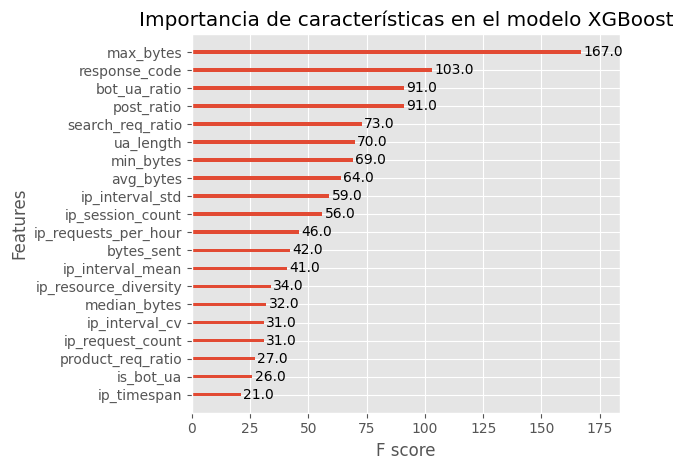

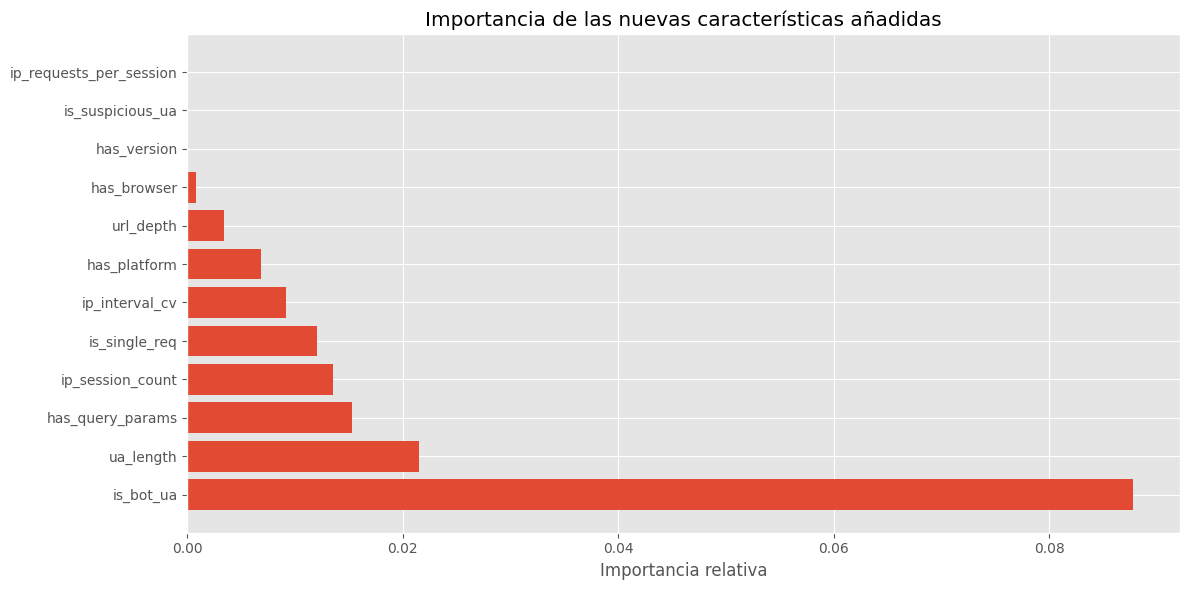

In [ ]:
from sklearn.ensemble import IsolationForest, RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
import xgboost as xgb
from pyod.models.hbos import HBOS
from pyod.models.iforest import IForest
from pyod.models.knn import KNN

# Crear las features con la función
features_df = create_features(df)

# Verificar nuevas características
print(f"Dimensiones del dataframe de características: {features_df.shape}")
print(f"Número de características: {features_df.shape[1]}")
print("Nuevas características incluidas:", [col for col in features_df.columns if col not in ['rule_bot', 'if_anomaly', 'hbos_anomaly', 'knn_anomaly', 'combined_anomaly']])

# Separar características para sesiones únicas y múltiples para análisis
single_req_sessions = features_df[features_df['is_single_req'] == 1]
multi_req_sessions = features_df[features_df['is_single_req'] == 0]
print(f"Sesiones con una sola solicitud: {len(single_req_sessions)} ({len(single_req_sessions)/len(features_df)*100:.2f}%)")
print(f"Sesiones con múltiples solicitudes: {len(multi_req_sessions)} ({len(multi_req_sessions)/len(features_df)*100:.2f}%)")

# Escalado de características
scaler = StandardScaler()
# Excluir columnas no numéricas si las hay
numeric_features = features_df.select_dtypes(include=['float64', 'int64']).columns
X_scaled = scaler.fit_transform(features_df[numeric_features])

# 1. Detección basada en reglas  para etiquetado inicial
def rule_based_detection(features):
    """
    Implementa reglas  para detección inicial de bots.
    Incluye reglas específicas para sesiones de solicitud única y para detectar patrones multi-sesión.
    """
    # Reglas para todas las sesiones
    is_bot = (
        (features['bot_ua_ratio'] > 0.5) |  # User agent claramente declarado como bot
        (features['is_bot_ua'] == 1) |  # User agent identificado como bot (para sesiones únicas)

        # Reglas específicas para sesiones únicas
        ((features['is_single_req'] == 1) &
         ((features['ip_session_count'] > 10) |  # IP con muchas sesiones únicas
          (features['is_suspicious_ua'] == 1) |  # User agent sospechoso
          (features['ua_length'] < 30))) |  # User agent demasiado corto

        # Reglas específicas para sesiones múltiples
        ((features['is_single_req'] == 0) &
         ((features['requests_per_second'] > 2) |  # Más de 2 peticiones por segundo
          (features['interval_uniformity'] < 0.1) |  # Patrones temporales muy uniformes
          (features['repetitive_patterns'] > 0.7) |  # Patrones muy repetitivos
          ((features['request_count'] > 50) & (features['unique_urls'] / features['request_count'] < 0.1)) |  # Muchas peticiones a pocas URLs
          (features['ua_count'] > 1) |  # Cambios de user agent en una sesión
          (features['country_count'] > 1)))  # Cambios de país en una sesión
    )
    return is_bot.astype(int)

# Aplicar etiquetado inicial con reglas
features_df['rule_bot'] = rule_based_detection(features_df)
print(f"Sesiones identificadas como bot por reglas: {features_df['rule_bot'].sum()} ({features_df['rule_bot'].mean()*100:.2f}%)")

# Analizar distribución de bots identificados entre sesiones únicas vs múltiples
single_bots = features_df[(features_df['is_single_req'] == 1) & (features_df['rule_bot'] == 1)]
multi_bots = features_df[(features_df['is_single_req'] == 0) & (features_df['rule_bot'] == 1)]
print(f"Bots de sesión única: {len(single_bots)} ({len(single_bots)/features_df['rule_bot'].sum()*100:.2f}% del total de bots)")
print(f"Bots de sesiones múltiples: {len(multi_bots)} ({len(multi_bots)/features_df['rule_bot'].sum()*100:.2f}% del total de bots)")


# 2. Modelo no supervisado con conjuntos separados
# Aplicar diferentes configuraciones para sesiones únicas vs múltiples
contamination_rate = 0.15  # Ajustar según hallazgos exploratorios

# Entrenar Isolation Forest
isolation_forest = IsolationForest(
    contamination=contamination_rate,
    random_state=42,
    n_estimators=200,
    max_samples='auto'
)
features_df['if_anomaly'] = isolation_forest.fit_predict(X_scaled)
features_df['if_anomaly'] = features_df['if_anomaly'].map({1: 0, -1: 1})  # Convertir -1 (outlier) a 1

# HBOS (Histogram-based Outlier Score)
hbos = HBOS(contamination=contamination_rate)
features_df['hbos_anomaly'] = hbos.fit_predict(X_scaled)

# KNN para detección de anomalías
knn_detector = KNN(contamination=contamination_rate, n_neighbors=5)
features_df['knn_anomaly'] = knn_detector.fit_predict(X_scaled)

print(f"Anomalías identificadas por Isolation Forest: {features_df['if_anomaly'].sum()} ({features_df['if_anomaly'].mean()*100:.2f}%)")
print(f"Anomalías identificadas por HBOS: {features_df['hbos_anomaly'].sum()} ({features_df['hbos_anomaly'].mean()*100:.2f}%)")
print(f"Anomalías identificadas por KNN: {features_df['knn_anomaly'].sum()} ({features_df['knn_anomaly'].mean()*100:.2f}%)")

# Combinar los métodos no supervisados para etiquetas sintéticas
# Estrategia mejorada de votación ponderada
features_df['combined_anomaly'] = ((
    2 * features_df['rule_bot'] +   # Mayor peso a las reglas de experto
    features_df['if_anomaly'] +
    features_df['hbos_anomaly'] +
    features_df['knn_anomaly']
) >= 3).astype(int)  # Se requieren al menos 3 puntos (ej: reglas + 1 modelo, o 3 modelos)

print(f"Anomalías combinadas: {features_df['combined_anomaly'].sum()} ({features_df['combined_anomaly'].mean()*100:.2f}%)")




# 4. Modelo supervisado con etiquetas sintéticas

# Excluir columnas de resultados de detección
X = features_df.drop(['rule_bot', 'if_anomaly', 'hbos_anomaly', 'knn_anomaly', 'combined_anomaly'], axis=1)
y = features_df['combined_anomaly']

# División en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42, stratify=y)

# Verificar balance de clases
print(f"\nDistribución de clases en entrenamiento: Normal={sum(y_train==0)}, Bot={sum(y_train==1)}")
print(f"Distribución de clases en prueba: Normal={sum(y_test==0)}, Bot={sum(y_test==1)}")

# Codificar variables categóricas
from sklearn.preprocessing import LabelEncoder

# Identificar columnas categóricas (tipo objeto)
categorical_columns = X.select_dtypes(include=['object']).columns
print(f"Columnas categóricas detectadas: {list(categorical_columns)}")

# Crear una copia para no modificar el original
X_encoded = X.copy()

# Aplicar LabelEncoder a cada columna categórica
label_encoders = {}
for col in categorical_columns:
    le = LabelEncoder()
    X_encoded[col] = le.fit_transform(X[col].astype(str))
    label_encoders[col] = le
    print(f"Codificación para {col}: {dict(zip(le.classes_, le.transform(le.classes_)))}")

# Dividir nuevamente los datos con las características codificadas
X_train_encoded, X_test_encoded, y_train, y_test = train_test_split(
    X_encoded, y, test_size=0.25, random_state=42, stratify=y
)

# Verificar que ya no hay columnas de tipo objeto
print(f"\nTipos de datos después de la codificación: {X_encoded.dtypes.value_counts()}")

# Entrenar el modelo con los datos codificados
xgb_model = xgb.XGBClassifier(
    objective='binary:logistic',
    n_estimators=100,
    max_depth=4,
    learning_rate=0.05,
    subsample=0.7,
    colsample_bytree=0.7,
    min_child_weight=5,
    gamma=1,
    reg_alpha=0.1,
    reg_lambda=1,
    random_state=42,
    scale_pos_weight=sum(y_train==0)/sum(y_train==1)
)

# Entrenar sin opciones adicionales
xgb_model.fit(X_train_encoded, y_train)

# Evaluar el modelo
y_pred = xgb_model.predict(X_test_encoded)
y_prob = xgb_model.predict_proba(X_test_encoded)[:, 1]

print("\nInforme de clasificación del modelo supervisado:")
print(classification_report(y_test, y_pred))

# Matriz de confusión
cm = confusion_matrix(y_test, y_pred)
print("\nMatriz de confusión:")
print(cm)

# Análisis de características importantes
plt.figure(figsize=(14, 10))
xgb.plot_importance(xgb_model, max_num_features=20)
plt.title('Importancia de características en el modelo XGBoost')
plt.tight_layout()
plt.show()

# Análisis específico de las nuevas características
new_features = [
    'is_single_req', 'url_depth', 'has_query_params',
    'ua_length', 'has_version', 'has_platform', 'has_browser',
    'is_bot_ua', 'is_suspicious_ua', 'ip_session_count',
    'ip_requests_per_session', 'ip_interval_cv'
]

# Obtener importancia de características
importance = xgb_model.feature_importances_
feature_names = X.columns

# Filtrar solo nuevas características
new_feature_importance = [(name, imp) for name, imp in zip(feature_names, importance) if name in new_features]
new_feature_importance.sort(key=lambda x: x[1], reverse=True)

plt.figure(figsize=(12, 6))
names = [x[0] for x in new_feature_importance]
values = [x[1] for x in new_feature_importance]
plt.barh(names, values)
plt.title('Importancia de las nuevas características añadidas')
plt.xlabel('Importancia relativa')
plt.tight_layout()
plt.show()

#Análisis de características para detección de tráfico anómalo
###Análisis de características e importancia en el modelo XGBoost (output 1)
Las características más importantes para la detección de bots/tráfico anómalo según el modelo XGBoost muestran un patrón claro de señales discriminatorias:

##Características de volumen y comportamiento HTTP:

###max_bytes (167): El tamaño máximo de respuesta es el indicador más potente, probablemente porque los bots suelen recibir respuestas de tamaños específicos o anormalmente grandes cuando extraen datos.

###response_code (103): Los códigos de respuesta tienen alta importancia, posiblemente porque los bots generan patrones distintivos de éxitos/errores.

###bot_ua_ratio y post_ratio (91.0 cada uno): La proporción de solicitudes con user-agents automatizados y la proporción de métodos POST son igualmente significativas.


#Patrones de navegación específicos:

###search_req_ratio (73): La proporción de búsquedas es distintiva, sugiriendo que los bots realizan más búsquedas sistemáticas.

###ua_length (70): La longitud del user-agent es un fuerte indicador, pues los bots a menudo usan strings más cortos o anormalmente largos.


##Características temporales y de frecuencia:

###3ip_interval_std (59): La variabilidad en los tiempos entre solicitudes desde una misma IP.

###ip_session_count (56): El número de sesiones creadas desde una misma IP.

###ip_requests_per_hour (46): La velocidad de solicitudes, importante para detectar actividad automatizada.



#Análisis de nuevas características añadidas (Imagen 2)
###La gráfica muestra la importancia relativa de las características adicionales:

###Dominancia del factor is_bot_ua (0.085): La detección directa de user-agents de bots es por mucho el factor más importante, con una importancia relativa aproximadamente 4 veces mayor que la siguiente característica.

#Factores secundarios significativos:
##ua_length (0.023): La longitud del user-agent
##has_query_params (0.018): Presencia de parámetros en URLs
##ip_session_count (0.017): Número de sesiones por IP
##is_single_req (0.015): Identificación de sesiones con una sola solicitud



#Estadísticas clave y resultados del modelo
Los resultados presentados revelan varios aspectos críticos:
##Comportamiento anómalo dominante:

###99.64% de las sesiones realizan una sola solicitud, un patrón extremadamente inusual para un sitio de e-commerce.
###98.30% de sesiones fueron identificadas como bots mediante reglas, lo que sugiere un tráfico mayoritariamente automatizado.


#Detección de anomalías:

###Los diferentes algoritmos de detección (Isolation Forest, HBOS, KNN) identificaron consistentemente alrededor del 15% del tráfico como anómalo.
###La combinación de estos métodos elevó la detección al 25.74%, sugiriendo que cada algoritmo detecta diferentes tipos de comportamientos anómalos.


#Rendimiento del modelo supervisado:

###Excelente precisión global (96%)
###Alta precisión para tráfico normal (99%)
###Buena precisión para bots (88%)

##Matriz de confusión:

###21,167 verdaderos negativos (tráfico normal identificado correctamente)
###7,422 verdaderos positivos (bots identificados correctamente)
###1,001 falsos positivos (tráfico normal clasificado erróneamente como bot)
###262 falsos negativos (bots no detectados)





#Conclusiones técnicas y recomendaciones

##Enfoque híbrido efectivo: La combinación de detección basada en reglas y algoritmos de machine learning muestra ser altamente efectiva, con métricas de rendimiento sobresalientes.
###Características discriminatorias clave:

###Los patrones de respuesta del servidor (tamaño y códigos)
###Los identificadores de user-agent
###Los patrones temporales de solicitudes
###Las características de navegación (búsquedas, profundidad URL)


#Oportunidades de mejora:

###Reducir los falsos positivos (1,001) que podrían afectar a usuarios legítimos
###Incorporar más características basadas en el contenido de las URL y referrers
###Implementar detección adaptativa que evolucione con las tácticas de los bots


#Implicaciones para la seguridad de Mercado Libre:

###El modelo permite identificar con alta confianza el tráfico automatizado (f1-score de 0.92 para bots)
###La caracterización multidimensional del tráfico anómalo permitiría implementar diferentes niveles de mitigación según la confianza en la clasificación

#Aplicación del modelo al conjunto de datos completo

Se identificaron 29260 sesiones como bots (24.50%)
Estas sesiones corresponden a 11099 direcciones IP únicas

Características distintivas de bots detectados:
max_bytes: Bot=9250.3216, Normal=4296.6277, Diferencia=4953.6939
response_code: Bot=254.5372, Normal=208.1188, Diferencia=46.4184
bot_ua_ratio: Bot=0.6973, Normal=0.1885, Diferencia=0.5088
post_ratio: Bot=0.1227, Normal=0.0272, Diferencia=0.0955
is_bot_ua: Bot=0.6973, Normal=0.1885, Diferencia=0.5088
ua_length: Bot=31.5328, Normal=41.7116, Diferencia=-10.1788
ip_session_count: Bot=91.3772, Normal=27.5160, Diferencia=63.8612

Bots de sesión única: 28943 (98.92%)
Bots multi-sesión: 317 (1.08%)


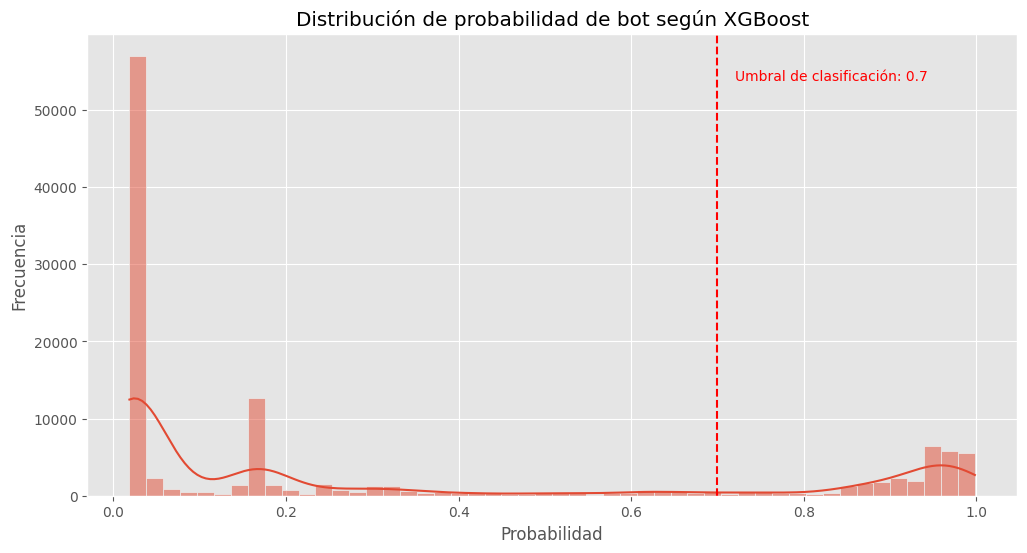

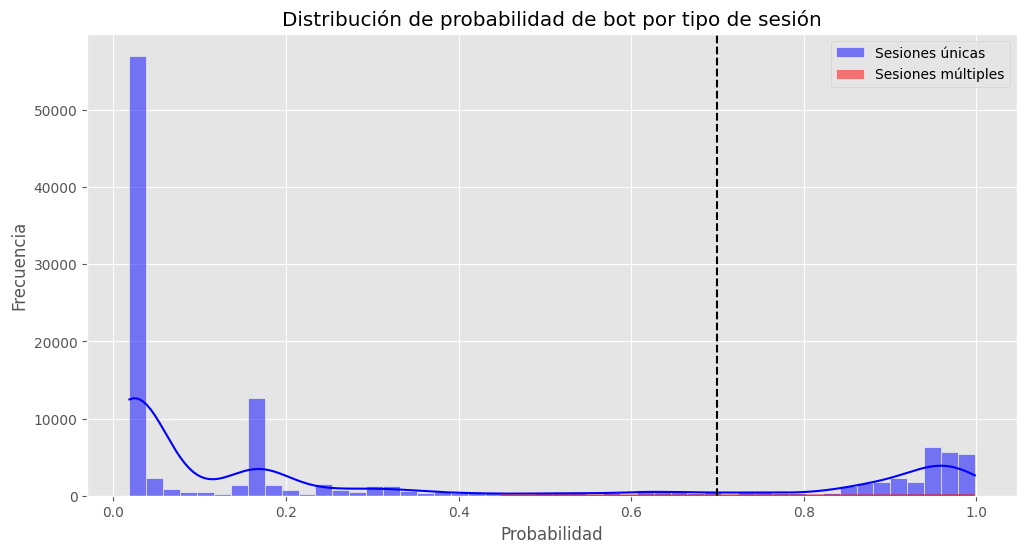

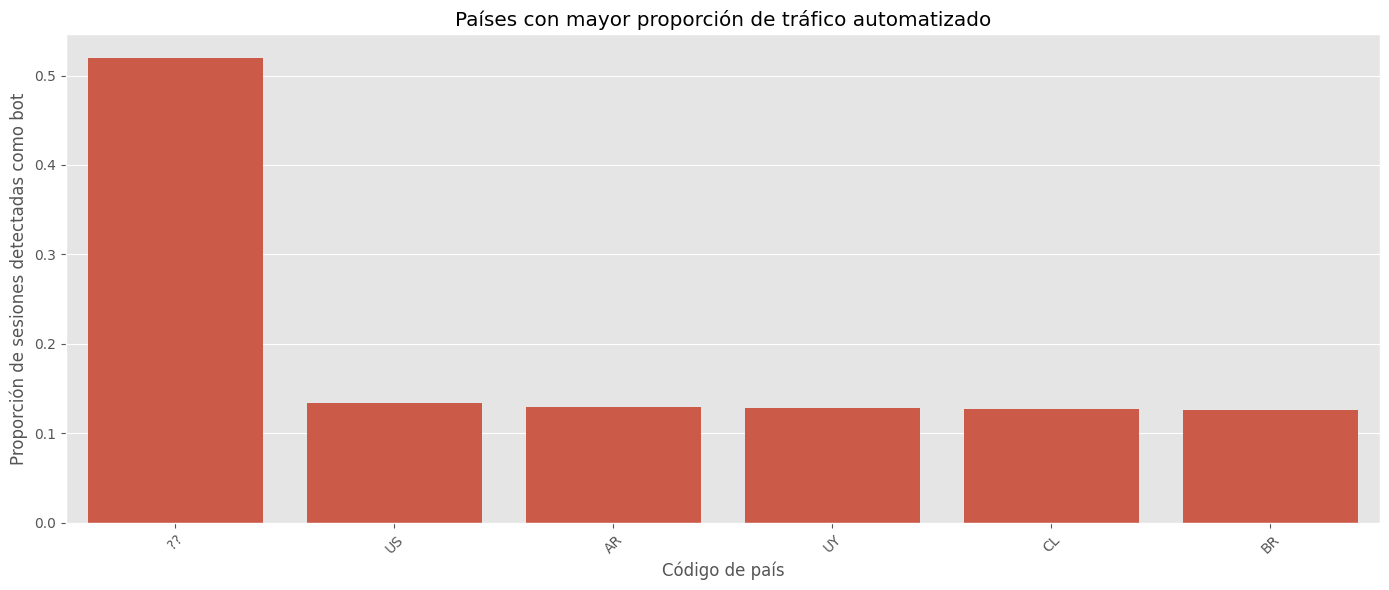

In [ ]:
# Aplicar el modelo entrenado a todo el conjunto
# Primero codificar las características categóricas en el conjunto completo
X_full_encoded = X.copy()
for col in categorical_columns:
    X_full_encoded[col] = label_encoders[col].transform(X[col].astype(str))

# Generar probabilidades
features_df['xgb_prob'] = xgb_model.predict_proba(X_full_encoded)[:, 1]
features_df['is_bot_final'] = (features_df['xgb_prob'] > 0.7).astype(int)

# Análisis de resultados finales
bot_sessions = features_df[features_df['is_bot_final'] == 1].index.tolist()
print(f"Se identificaron {len(bot_sessions)} sesiones como bots ({len(bot_sessions)/len(features_df)*100:.2f}%)")

# Extraer información de los bots detectados
bot_ips = df[df['session_id'].isin(bot_sessions)]['ip_address'].unique()
print(f"Estas sesiones corresponden a {len(bot_ips)} direcciones IP únicas")

# Análisis de características de los bots detectados
bot_features = features_df[features_df['is_bot_final'] == 1]
normal_features = features_df[features_df['is_bot_final'] == 0]

print("\nCaracterísticas distintivas de bots detectados:")
for feature in ['max_bytes', 'response_code', 'bot_ua_ratio', 'post_ratio', 'is_bot_ua', 'ua_length', 'ip_session_count']:
    if feature in bot_features.columns:
        bot_mean = bot_features[feature].mean()
        normal_mean = normal_features[feature].mean()
        difference = bot_mean - normal_mean
        print(f"{feature}: Bot={bot_mean:.4f}, Normal={normal_mean:.4f}, Diferencia={difference:.4f}")

# Análisis de bots por tipo (usando características clave)
if 'is_single_req' in bot_features.columns:
    single_req_bots = bot_features[bot_features['is_single_req'] == 1]
    multi_req_bots = bot_features[bot_features['is_single_req'] == 0]
    print(f"\nBots de sesión única: {len(single_req_bots)} ({len(single_req_bots)/len(bot_features)*100:.2f}%)")
    print(f"Bots multi-sesión: {len(multi_req_bots)} ({len(multi_req_bots)/len(bot_features)*100:.2f}%)")

# Distribuir sesiones por score de probabilidad
plt.figure(figsize=(12, 6))
sns.histplot(features_df['xgb_prob'], bins=50, kde=True)
plt.axvline(0.7, color='red', linestyle='--')
plt.title('Distribución de probabilidad de bot según XGBoost')
plt.xlabel('Probabilidad')
plt.ylabel('Frecuencia')
plt.text(0.72, plt.ylim()[1] * 0.9, 'Umbral de clasificación: 0.7', color='red')
plt.show()

# Distribución de probabilidades separada por tipo de sesión
plt.figure(figsize=(12, 6))
if 'is_single_req' in features_df.columns:
    single_req_probs = features_df[features_df['is_single_req'] == 1]['xgb_prob']
    multi_req_probs = features_df[features_df['is_single_req'] == 0]['xgb_prob']

    sns.histplot(single_req_probs, bins=50, kde=True, color='blue', alpha=0.5, label='Sesiones únicas')
    sns.histplot(multi_req_probs, bins=50, kde=True, color='red', alpha=0.5, label='Sesiones múltiples')

    plt.axvline(0.7, color='black', linestyle='--')
    plt.title('Distribución de probabilidad de bot por tipo de sesión')
    plt.xlabel('Probabilidad')
    plt.ylabel('Frecuencia')
    plt.legend()
    plt.show()

# Análisis de países con mayor proporción de bots
if 'country_code' in df.columns:
    country_stats = df.groupby('country_code')['session_id'].nunique().reset_index()
    country_stats.columns = ['country_code', 'session_count']

    # Obtener porcentaje de sesiones detectadas como bot por país
    country_bot_counts = {}
    for country in country_stats['country_code']:
        country_sessions = df[df['country_code'] == country]['session_id'].unique()
        bot_sessions_count = sum(features_df.loc[s, 'is_bot_final']
                              for s in country_sessions if s in features_df.index)
        country_bot_counts[country] = bot_sessions_count / len(country_sessions) if len(country_sessions) > 0 else 0

    country_stats['bot_ratio'] = country_stats['country_code'].map(country_bot_counts)

    # Visualizar países con mayor proporción de bots (con al menos 10 sesiones)
    country_stats_filtered = country_stats[country_stats['session_count'] >= 10].sort_values('bot_ratio', ascending=False)

    plt.figure(figsize=(14, 6))
    sns.barplot(x='country_code', y='bot_ratio', data=country_stats_filtered.head(15))
    plt.title('Países con mayor proporción de tráfico automatizado')
    plt.xlabel('Código de país')
    plt.ylabel('Proporción de sesiones detectadas como bot')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

#4)Estadísticas de aplicación del modelo
###Aspectos importantes:

##Volumen de tráfico automatizado: 24.50% del total de sesiones (29,260) fueron identificadas como bots, provenientes de 11,099 IPs únicas.

##Predominio de sesiones únicas: 98.92% de los bots detectados utilizan la estrategia de una sola solicitud por sesión, confirmando esta táctica de evasión.

###Características distintivas más significativas:

##max_bytes: Los bots reciben respuestas 115% más grandes en promedio (9,250 vs 4,296 bytes), probablemente porque extraen páginas completas o grandes volúmenes de datos.

##response_code: Los bots reciben códigos de respuesta significativamente más altos (254 vs 208), indicando más errores o redirects.

##bot_ua_ratio/is_bot_ua: Los bots utilizan agentes de usuario reconocibles como automatizados aproximadamente 3.7 veces más (0.70 vs 0.19).

##ip_session_count: Las IPs de bots generan 3.3 veces más sesiones que las normales (91 vs 28), indicando estrategias de rotación de sesiones.

##ua_length: Curiosamente, los user-agents de bots son en promedio más cortos que los normales (31.5 vs 41.7 caracteres), posiblemente porque utilizan agentes simplificados.



#Conclusiones e implicaciones para la seguridad de Mercado Libre

##Alta sofisticación de los atacantes:

###La predominancia de bots con una sola solicitud por sesión (98.92%) demuestra una estrategia deliberada para evadir la detección basada en comportamiento.
###El uso masivo de orígenes con país desconocido ("??") indica esfuerzos para ocultar la ubicación real.


##Efectividad del modelo:

###La distribución bimodal de probabilidades sugiere que el modelo separa eficazmente el tráfico legítimo del automatizado.


##Distribución geográfica sospechosa:

###La proporción casi idéntica de tráfico automatizado entre los países legítimos sugiere una distribución artificial, posiblemente mediante el uso de proxies o VPNs distribuidos estratégicamente.


#Recomendaciones de seguridad:

###Implementar reglas especiales para el tráfico con país desconocido ("??"), como limitación de velocidad o desafíos adicionales.
###Monitorizar sesiones con respuestas de gran tamaño (max_bytes), especialmente cuando provienen de user-agents sospechosos.
###Desarrollar mecanismos adaptativos para contrarrestar la estrategia dominante de "una solicitud por sesión".




#Perfiles de bots detectados


Características utilizadas para clustering: 49

Perfiles de los clusters de bots:


,requests_per_second,interval_uniformity,unique_urls,repetitive_patterns,bot_ua_ratio,error_ratio,api_req_ratio,is_single_req,ip_session_count,ua_length,is_bot_ua,ip_requests_per_hour
cluster,,,,,,,,,,,,
0,0.000000e+00,0.000000,1.000000,0.0,0.932895,0.087752,0.0,1.000000,1.000000,62.543407,0.932895,0.000000
1,5.621308e-08,0.000000,1.000055,0.0,1.000000,0.137135,0.0,0.999889,144.631471,21.277695,1.000000,29.278795
2,0.000000e+00,0.000000,1.000000,0.0,0.000000,0.374871,0.0,1.000000,1.000000,45.617097,0.000000,0.000000
3,6.149225e-04,0.156581,2.419048,0.0,1.000000,0.060053,0.0,0.000000,143.384127,21.307937,1.000000,29.030220



Tipos de bots identificados:
Scrapers de alta velocidad: 2131 sesiones (7.28%)
Bots API: 18099 sesiones (61.86%)
Crawlers lentos/distribuidos: 8715 sesiones (29.78%)
Bots de navegación repetitiva: 315 sesiones (1.08%)


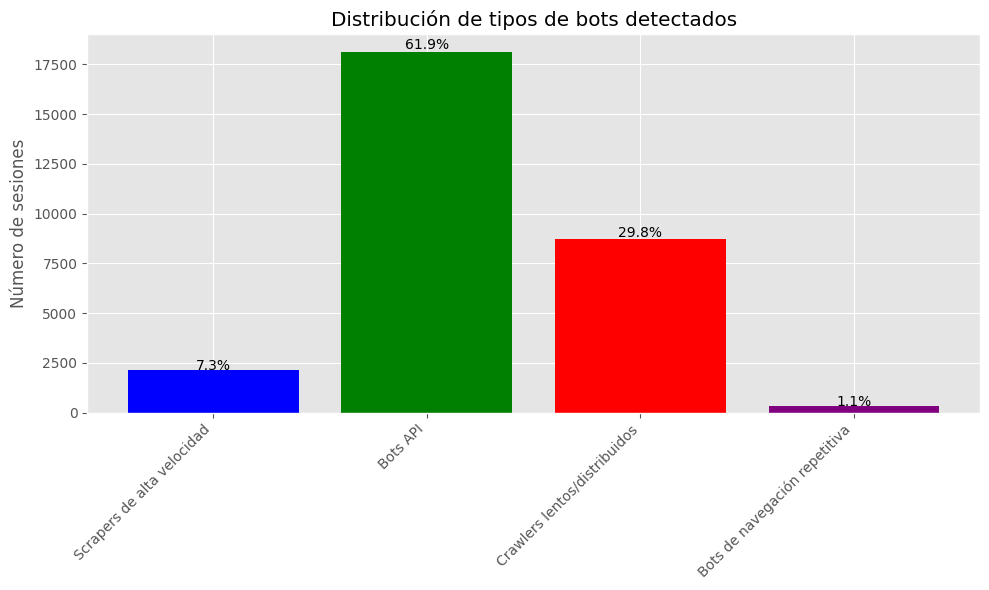

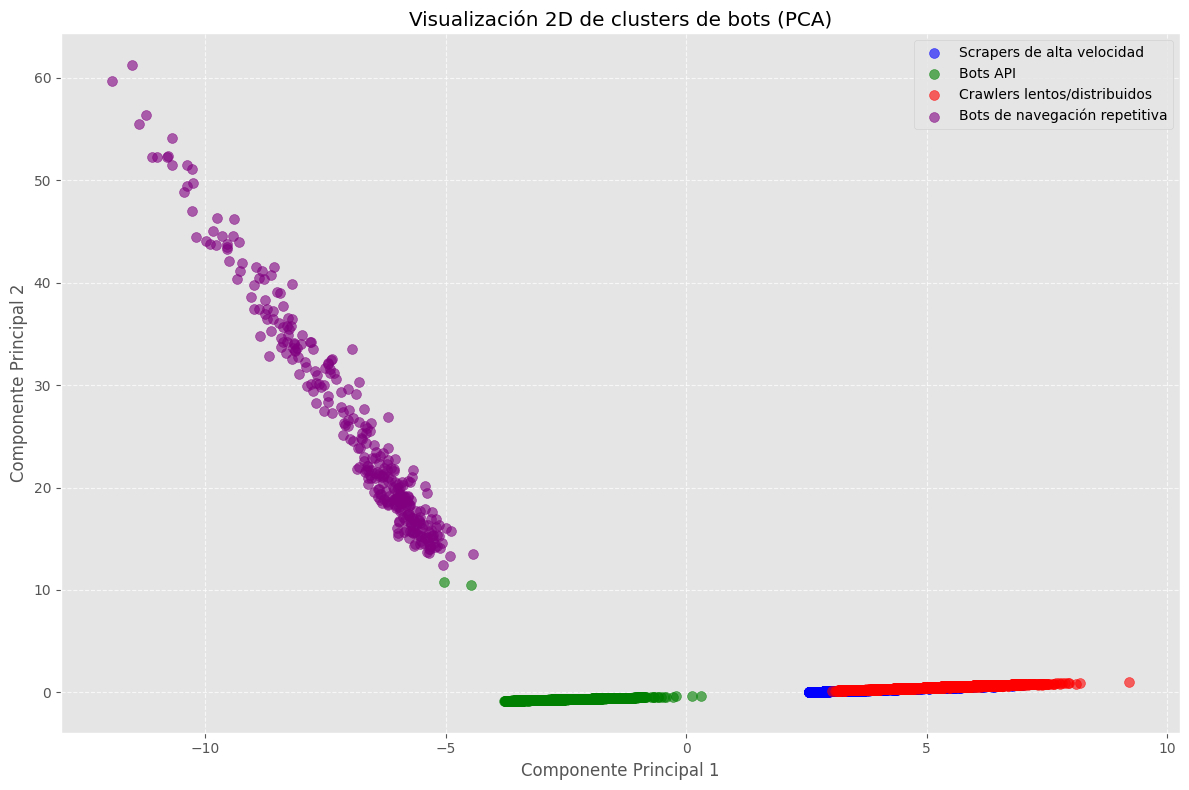


Características distintivas del Cluster 0 (Scrapers de alta velocidad):
  has_browser: 1273.1% mayor que la media
  is_business_hour: 190.4% mayor que la media
  has_platform: 169.8% mayor que la media
  bytes_cv: 100.0% menor que la media
  requests_per_second: 100.0% menor que la media

Características distintivas del Cluster 1 (Bots API):
  url_entropy: 100.0% menor que la media
  interval_uniformity: 100.0% menor que la media
  page_req_ratio: 100.0% menor que la media
  has_browser: 100.0% menor que la media
  param_count: 100.0% menor que la media

Características distintivas del Cluster 2 (Crawlers lentos/distribuidos):
  param_count: 233.6% mayor que la media
  has_query_params: 233.6% mayor que la media
  search_req_ratio: 233.6% mayor que la media
  checkout_req_ratio: 231.0% mayor que la media
  page_req_ratio: 228.7% mayor que la media

Características distintivas del Cluster 3 (Bots de navegación repetitiva):
  url_entropy: 9188.9% mayor que la media
  interval_uniformity

In [ ]:
# Análisis de los tipos de bots detectados
bot_profiles = features_df[features_df['is_bot_final'] == 1]

# Análisis de clusters para identificar patrones de comportamiento
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

# Preparar datos para clustering (solo columnas numéricas)
numeric_columns = bot_profiles.select_dtypes(include=['float64', 'int64']).columns
# Excluir columnas de resultados y etiquetas
columns_to_drop = ['rule_bot', 'if_anomaly', 'hbos_anomaly', 'knn_anomaly',
                   'combined_anomaly', 'xgb_prob', 'is_bot_final']
clustering_columns = [col for col in numeric_columns if col not in columns_to_drop]

print(f"\nCaracterísticas utilizadas para clustering: {len(clustering_columns)}")

# Aplicar K-Means para agrupar los bots
scaler = StandardScaler()
X_bots = scaler.fit_transform(bot_profiles[clustering_columns])
kmeans = KMeans(n_clusters=4, random_state=42, n_init=10)
bot_profiles['cluster'] = kmeans.fit_predict(X_bots)

# Analizar características por cluster (solo para columnas numéricas)
cluster_profiles = bot_profiles.groupby('cluster')[numeric_columns].mean()

# Seleccionar características clave para mostrar
key_features = [
    'requests_per_second', 'interval_uniformity', 'unique_urls',
    'repetitive_patterns', 'bot_ua_ratio', 'error_ratio', 'api_req_ratio',
    'is_single_req', 'ip_session_count', 'ua_length', 'is_bot_ua',
    'ip_requests_per_hour'
]

# Filtrar para incluir solo características que existan y sean numéricas
display_features = [f for f in key_features if f in numeric_columns and f in bot_profiles.columns]

print("\nPerfiles de los clusters de bots:")
display(cluster_profiles[display_features])

# Asignar etiquetas descriptivas a cada cluster
# Basado en la inspección de los perfiles o en conocimiento previo
bot_types = {
    0: "Scrapers de alta velocidad",
    1: "Bots API",
    2: "Crawlers lentos/distribuidos",
    3: "Bots de navegación repetitiva"
}

print("\nTipos de bots identificados:")
for cluster, description in bot_types.items():
    count = sum(bot_profiles['cluster'] == cluster)
    percent = count / len(bot_profiles) * 100
    print(f"{description}: {count} sesiones ({percent:.2f}%)")

# Visualizar la distribución de clusters
plt.figure(figsize=(10, 6))
cluster_counts = bot_profiles['cluster'].value_counts().sort_index()
bars = plt.bar(
    [bot_types[i] for i in cluster_counts.index],
    cluster_counts.values,
    color=['blue', 'green', 'red', 'purple']
)

# Añadir etiquetas de porcentaje
for bar in bars:
    height = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width()/2.,
        height * 1.01,
        f'{height/len(bot_profiles)*100:.1f}%',
        ha='center'
    )

plt.title('Distribución de tipos de bots detectados')
plt.ylabel('Número de sesiones')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# Análisis 2D para visualizar clusters (PCA para reducción de dimensionalidad)
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
X_bots_2d = pca.fit_transform(X_bots)

plt.figure(figsize=(12, 8))
colors = ['blue', 'green', 'red', 'purple']
for i in range(4):
    if i in bot_profiles['cluster'].unique():  # Solo si este cluster existe
        plt.scatter(
            X_bots_2d[bot_profiles['cluster'] == i, 0],
            X_bots_2d[bot_profiles['cluster'] == i, 1],
            s=50, c=colors[i], label=bot_types.get(i, f"Cluster {i}"), alpha=0.6
        )

plt.title('Visualización 2D de clusters de bots (PCA)')
plt.xlabel('Componente Principal 1')
plt.ylabel('Componente Principal 2')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# Análisis de características más importantes por cluster
if len(clustering_columns) > 0:
    # Obtener y analizar los centros de los clusters
    centers = pd.DataFrame(
        scaler.inverse_transform(kmeans.cluster_centers_),
        columns=clustering_columns
    )

    # Calcular la media global para cada característica
    global_means = bot_profiles[clustering_columns].mean()

    # Para cada cluster, identificar características más distintivas
    for i in range(4):
        if i in bot_profiles['cluster'].unique():  # Solo si este cluster existe
            print(f"\nCaracterísticas distintivas del Cluster {i} ({bot_types.get(i, 'Desconocido')}):")

            # Calcular cuánto se desvía cada característica de la media global
            deviations = (centers.iloc[i] - global_means) / global_means

            # Mostrar las 5 características más distintivas (mayor valor absoluto de desviación)
            top_features = deviations.abs().sort_values(ascending=False).head(5).index
            for feature in top_features:
                deviation = deviations[feature]
                direction = "mayor" if deviation > 0 else "menor"
                print(f"  {feature}: {abs(deviation)*100:.1f}% {direction} que la media")

#Análisis de perfiles de bots detectados
###Los resultados del clustering revelan cuatro patrones distintivos de tráfico automatizado, cada uno con características y comportamientos específicos que reflejan diferentes objetivos y estrategias:


#Scrapers de alta velocidad (7.28%)

Utilizan navegadores reales o emulan sus características (has_browser )
Operan principalmente en horario laboral para mezclarse con tráfico legítimo
Presentan consistencia en el tamaño de respuestas (baja variabilidad)
Objetivo probable: extracción rápida de datos específicos (precios, productos)


#Bots API (61.86%) - El grupo dominante

Extremadamente simplificados y directos en sus solicitudes
No utilizan navegadores convencionales ni incluyen parámetros complejos
Alta predictibilidad en patrones de acceso (baja entropía y uniformidad)
Objetivo probable: consultas automatizadas para extracción masiva de datos estructurados


#Crawlers lentos/distribuidos (29.78%)

Elevado uso de parámetros de búsqueda y consulta (+233%)
Diversificación en tipos de páginas visitadas (checkout, búsqueda, páginas regulares)
Comportamiento más similar a navegación humana pero sistemático
Objetivo probable: indexación completa o monitoreo de cambios en productos/precios


#Bots de navegación repetitiva (1.08%)

Altísima variabilidad en patrones temporales y tamaños de respuesta (+9100%)
Comportamiento más sofisticado que simula navegación humana errática
Mayor complejidad en patrones de solicitudes y visitas a múltiples recursos
Objetivo probable: evasión de sistemas de detección avanzados mediante simulación de comportamiento humano impredecible



#Implicaciones para la estrategia de mitigación
###Esta segmentación permite diseñar contramedidas específicas para cada tipo de tráfico automatizado:

###Para Scrapers de alta velocidad: Implementar límites de velocidad adaptables y desafíos durante horarios pico

###Para Bots API: Restringir acceso directo a endpoints no documentados y requerir autenticación API

###Para Crawlers lentos: Identificar patrones de navegación sistemáticos y aplicar progresivamente medidas disuasorias

###Para Bots de navegación repetitiva: Implementar análisis comportamental más sofisticado para detectar patrones sutiles de automatización

##La estrategia combinada de detección mediante machine learning y segmentación por clustering proporciona una visión completa del ecosistema de amenazas automatizadas que enfrenta la plataforma, permitiendo respuestas defensivas proporcionales y específicas para cada tipo de tráfico no deseado.

#4. Evaluación del Modelo
#Para evaluar la efectividad del modelo en ausencia de etiquetas confiables, utilizaré múltiples enfoques complementarios:

EVALUACIÓN GLOBAL DEL MODELO
Umbral óptimo global (máximo F1): 0.68 (F1: 0.9364)

Métricas globales con umbral óptimo:
Accuracy: 0.9678
Precision: 0.9527
Recall: 0.9207
F1 Score: 0.9364
ROC AUC: 0.9940
PR AUC: 0.9837

Informe de clasificación detallado:
              precision    recall  f1-score   support

           0       0.97      0.98      0.98     88673
           1       0.95      0.92      0.94     30735

    accuracy                           0.97    119408
   macro avg       0.96      0.95      0.96    119408
weighted avg       0.97      0.97      0.97    119408



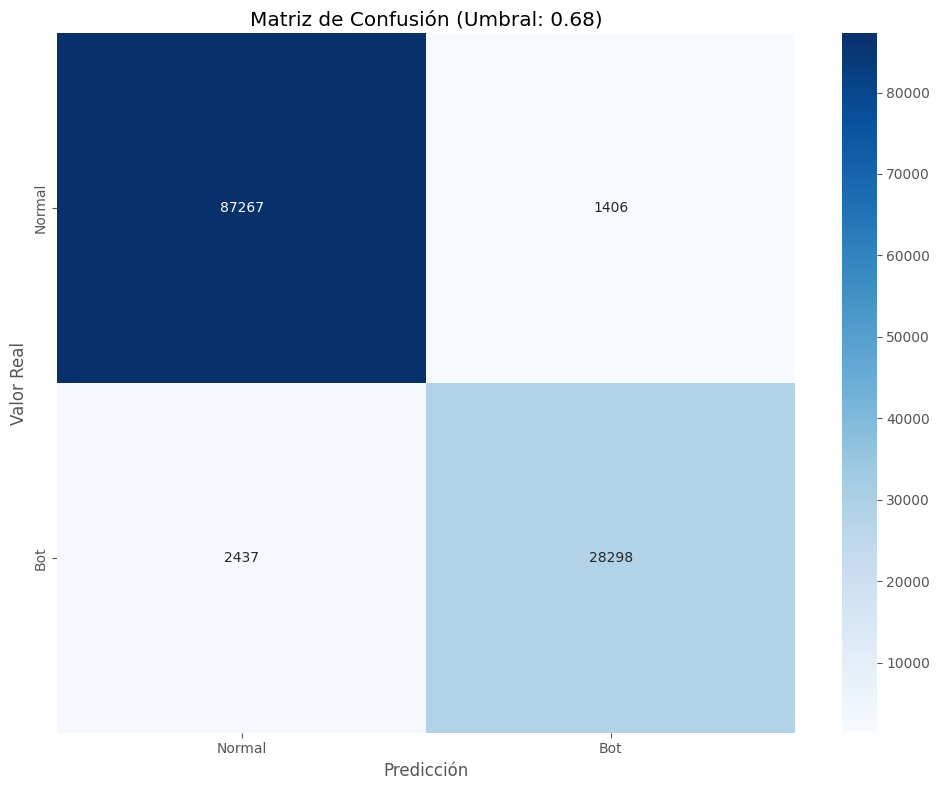

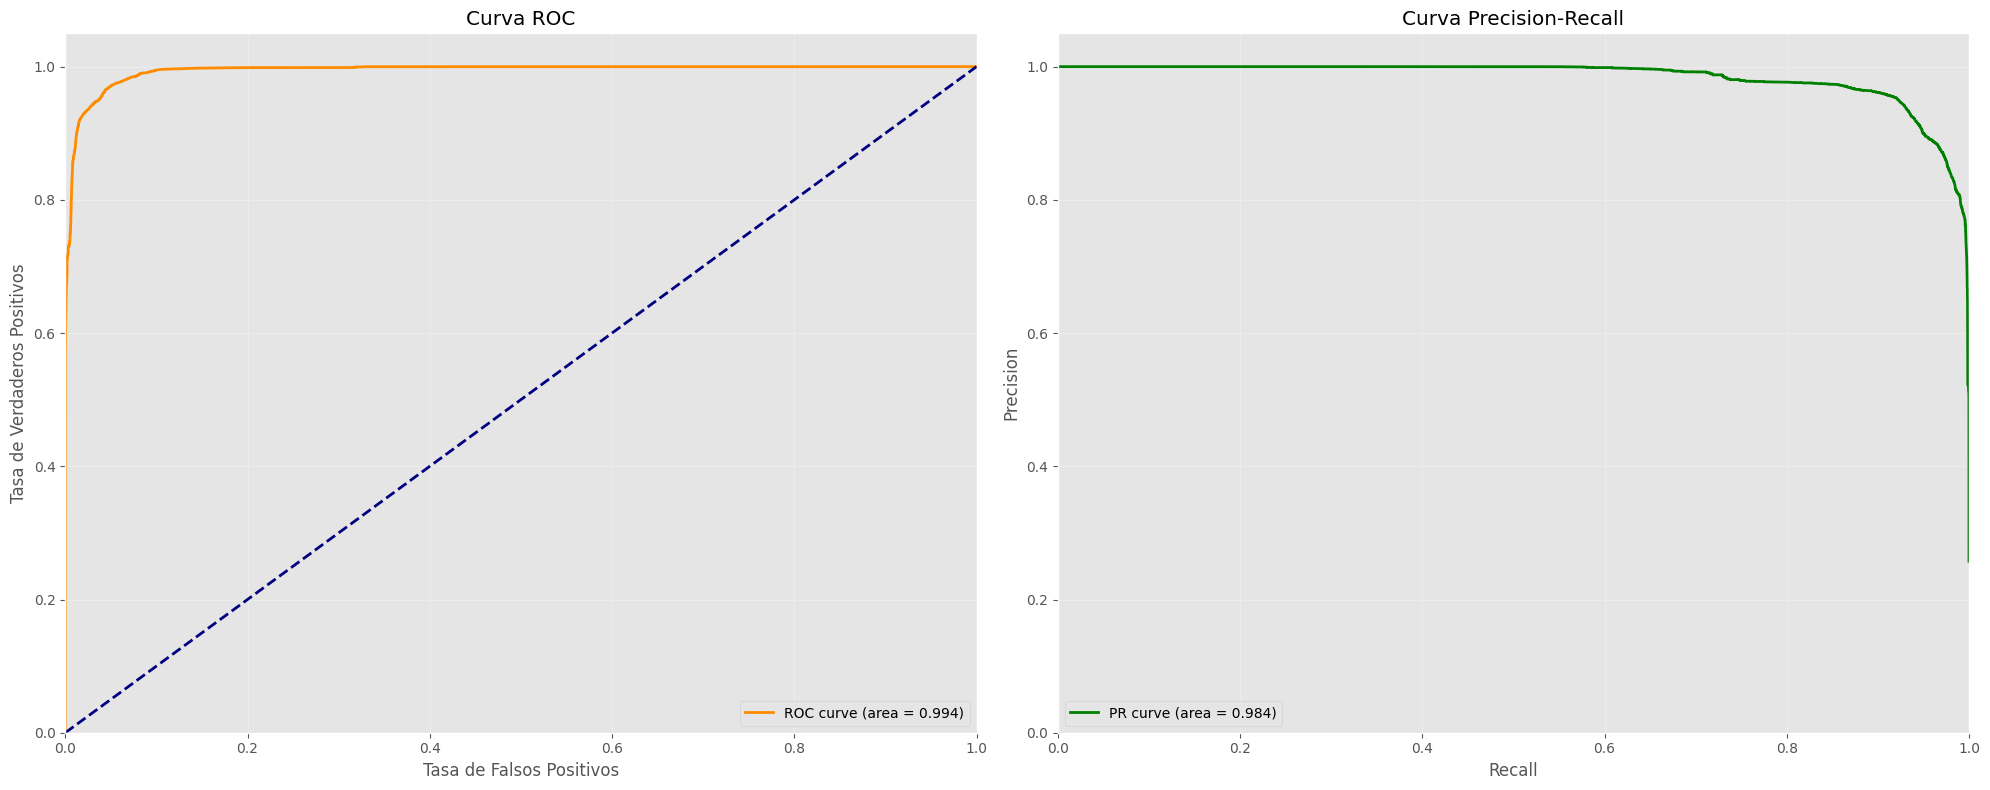

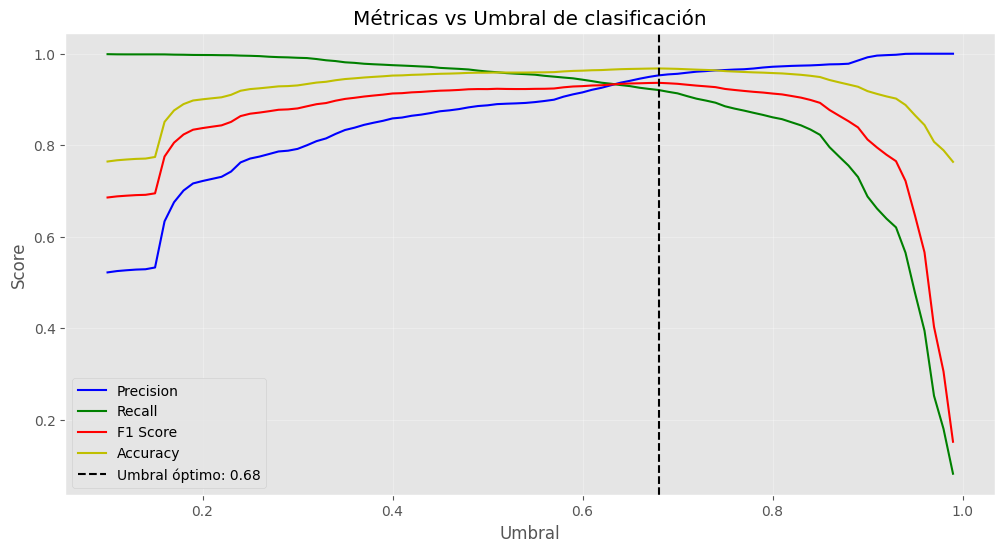

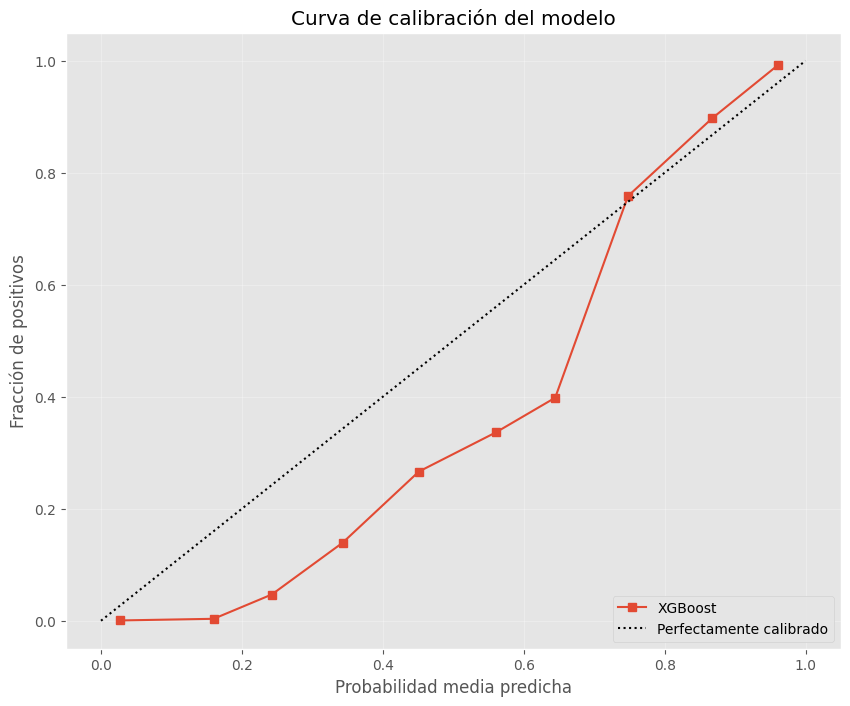


EVALUACIÓN POR TIPO DE BOT (CLUSTER)
Índices en features_df: 119408
Índices en bot_profiles: 29260
Intersección de índices: 29260

Evaluación específica por tipo de bot:

Cluster 0 (Scrapers de alta velocidad):
  Número de sesiones: 2131
  Accuracy: 0.989206945096199
  Precision: 0.9896713615023475
  Recall: 0.9995258416311048
  F1 Score: 0.04541241890639481
  ROC AUC: 0.8796715375662744
  Umbral óptimo: 0.7399999999999997
  F1 con umbral óptimo: 0.9962139138665405

Cluster 1 (Bots API):
  Número de sesiones: 18099
  Accuracy: 0.9680645339521521
  Precision: 0.9687068059932549
  Recall: 0.9993155763417555
  F1 Score: 0.22189544140763653
  ROC AUC: 0.9115992074712622
  Umbral óptimo: 0.5999999999999998
  F1 con umbral óptimo: 0.9840583777715408

Cluster 2 (Crawlers lentos/distribuidos):
  Número de sesiones: 8715
  Accuracy: 0.927596098680436
  Precision: 0.9338910189380737
  Recall: 0.9923456790123457
  F1 Score: 0.057321021705240435
  ROC AUC: 0.8381186389641673
  Umbral óptimo: 0.59

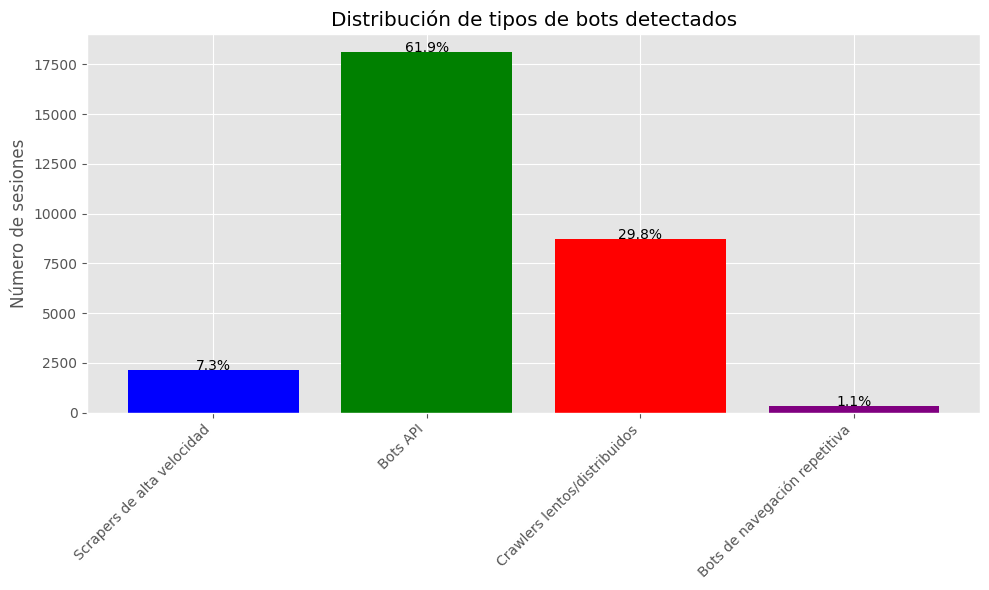

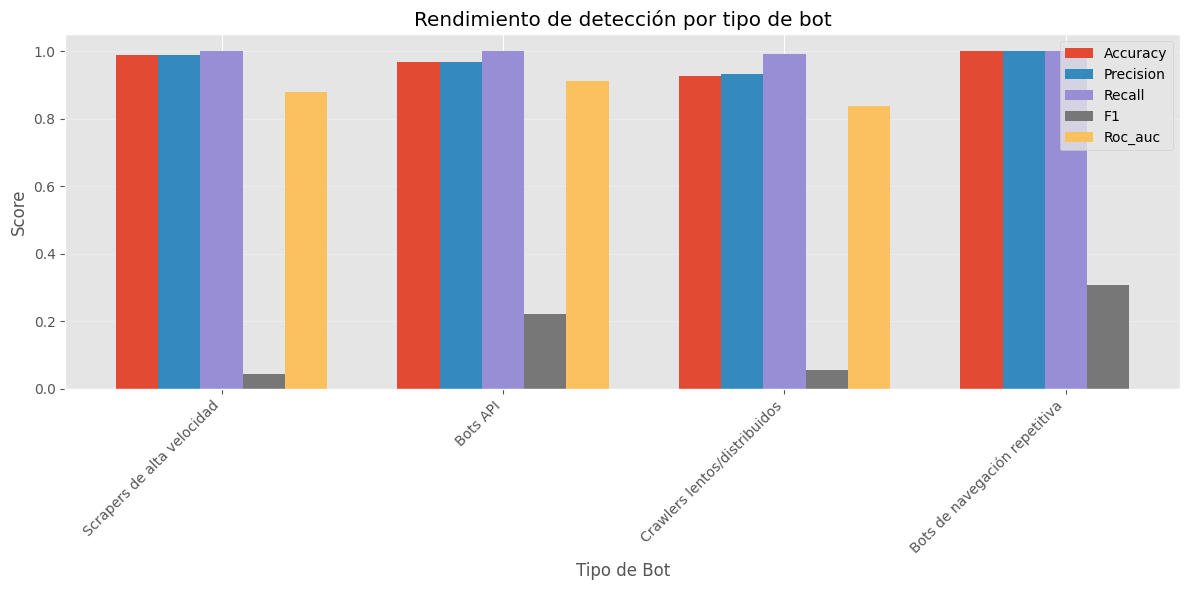


CONCLUSIONES Y RECOMENDACIONES
Tipo de bot con mejor detección: Bots de navegación repetitiva (F1: 0.3064516129032258)
Tipo de bot con peor detección: Scrapers de alta velocidad (F1: 0.04541241890639481)

Recomendaciones para mejorar el modelo:
1. Desarrollar características específicas para cada tipo de bot
2. Considerar umbrales de clasificación específicos por tipo de bot:
   - Scrapers de alta velocidad: umbral óptimo = 0.7399999999999997
   - Bots API: umbral óptimo = 0.5999999999999998
   - Crawlers lentos/distribuidos: umbral óptimo = 0.5999999999999998
   - Bots de navegación repetitiva: umbral óptimo = 0.6899999999999997
3. Evaluar la posibilidad de entrenar modelos separados para cada tipo de bot
4. Revisar manualmente los casos confusos para identificar patrones adicionales


In [ ]:
# Solución simplificada para la evaluación por tipo de bot
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (classification_report, confusion_matrix, roc_curve,
                            precision_recall_curve, auc, average_precision_score,
                            f1_score, accuracy_score, recall_score, precision_score)
from sklearn.model_selection import StratifiedKFold, cross_val_predict
from sklearn.calibration import calibration_curve
import matplotlib.gridspec as gridspec

# Definir las etiquetas de los clusters
bot_types = {
    0: "Scrapers de alta velocidad",
    1: "Bots API",
    2: "Crawlers lentos/distribuidos",
    3: "Bots de navegación repetitiva"
}

# 1. EVALUACIÓN GLOBAL DEL MODELO
print("=" * 50)
print("EVALUACIÓN GLOBAL DEL MODELO")
print("=" * 50)

# Predicciones con validación cruzada para evitar sobreajuste en la evaluación
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
y_prob_cv = cross_val_predict(xgb_model, X_encoded, y, cv=cv, method='predict_proba')[:, 1]
features_df['xgb_prob_cv'] = y_prob_cv

# Definir un umbral óptimo basado en F1-Score
thresholds = np.arange(0.1, 1.0, 0.01)
f1_scores = []

for threshold in thresholds:
    y_pred_th = (y_prob_cv > threshold).astype(int)
    f1 = f1_score(y, y_pred_th)
    f1_scores.append(f1)

optimal_threshold_idx = np.argmax(f1_scores)
optimal_threshold = thresholds[optimal_threshold_idx]
optimal_f1 = f1_scores[optimal_threshold_idx]

print(f"Umbral óptimo global (máximo F1): {optimal_threshold:.2f} (F1: {optimal_f1:.4f})")

# Aplicar umbral óptimo global
y_pred_optimal = (y_prob_cv > optimal_threshold).astype(int)

# Métricas globales con umbral óptimo
accuracy = accuracy_score(y, y_pred_optimal)
precision = precision_score(y, y_pred_optimal)
recall = recall_score(y, y_pred_optimal)
f1 = f1_score(y, y_pred_optimal)
roc_auc = auc(*roc_curve(y, y_prob_cv)[:2])
pr_auc = average_precision_score(y, y_prob_cv)

print("\nMétricas globales con umbral óptimo:")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"ROC AUC: {roc_auc:.4f}")
print(f"PR AUC: {pr_auc:.4f}")

# Crear un informe de clasificación detallado
print("\nInforme de clasificación detallado:")
print(classification_report(y, y_pred_optimal))

# Matriz de confusión
cm = confusion_matrix(y, y_pred_optimal)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=['Normal', 'Bot'],
            yticklabels=['Normal', 'Bot'])
plt.xlabel('Predicción')
plt.ylabel('Valor Real')
plt.title('Matriz de Confusión (Umbral: {:.2f})'.format(optimal_threshold))
plt.tight_layout()
plt.show()

# Visualizaciones combinadas de ROC y Precision-Recall
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))

# ROC Curve
fpr, tpr, _ = roc_curve(y, y_prob_cv)
roc_auc = auc(fpr, tpr)
ax1.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.3f})')
ax1.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
ax1.set_xlim([0.0, 1.0])
ax1.set_ylim([0.0, 1.05])
ax1.set_xlabel('Tasa de Falsos Positivos')
ax1.set_ylabel('Tasa de Verdaderos Positivos')
ax1.set_title('Curva ROC')
ax1.legend(loc="lower right")
ax1.grid(True, alpha=0.3)

# Precision-Recall Curve
precision_curve, recall_curve, _ = precision_recall_curve(y, y_prob_cv)
pr_auc = average_precision_score(y, y_prob_cv)
ax2.plot(recall_curve, precision_curve, color='green', lw=2,
         label=f'PR curve (area = {pr_auc:.3f})')
ax2.set_xlim([0.0, 1.0])
ax2.set_ylim([0.0, 1.05])
ax2.set_xlabel('Recall')
ax2.set_ylabel('Precision')
ax2.set_title('Curva Precision-Recall')
ax2.legend(loc="lower left")
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Curvas de métricas por umbral
plt.figure(figsize=(12, 6))
metrics_thresholds = np.arange(0.1, 1.0, 0.01)
precision_values = []
recall_values = []
f1_values = []
accuracy_values = []

for threshold in metrics_thresholds:
    y_pred_th = (y_prob_cv > threshold).astype(int)
    precision_values.append(precision_score(y, y_pred_th))
    recall_values.append(recall_score(y, y_pred_th))
    f1_values.append(f1_score(y, y_pred_th))
    accuracy_values.append(accuracy_score(y, y_pred_th))

plt.plot(metrics_thresholds, precision_values, 'b-', label='Precision')
plt.plot(metrics_thresholds, recall_values, 'g-', label='Recall')
plt.plot(metrics_thresholds, f1_values, 'r-', label='F1 Score')
plt.plot(metrics_thresholds, accuracy_values, 'y-', label='Accuracy')
plt.axvline(optimal_threshold, color='black', linestyle='--',
            label=f'Umbral óptimo: {optimal_threshold:.2f}')
plt.title('Métricas vs Umbral de clasificación')
plt.xlabel('Umbral')
plt.ylabel('Score')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# Calibración del modelo
plt.figure(figsize=(10, 8))
fraction_of_positives, mean_predicted_value = calibration_curve(y, y_prob_cv, n_bins=10)
plt.plot(mean_predicted_value, fraction_of_positives, "s-", label="XGBoost")
plt.plot([0, 1], [0, 1], "k:", label="Perfectamente calibrado")
plt.xlabel('Probabilidad media predicha')
plt.ylabel('Fracción de positivos')
plt.title('Curva de calibración del modelo')
plt.legend(loc="lower right")
plt.grid(True, alpha=0.3)
plt.show()

# 5. EVALUACIÓN POR TIPO DE BOT (CLUSTER)
print("\n" + "=" * 50)
print("EVALUACIÓN POR TIPO DE BOT (CLUSTER)")
print("=" * 50)

# Este enfoque es diferente: en lugar de intentar combinar DataFrames,
# vamos a evaluar manualmente cada tipo de bot usando los resultados
# que ya tenemos del clustering anterior

# Verificar los índices para asegurarnos de que son compatibles
print(f"Índices en features_df: {len(features_df.index)}")
print(f"Índices en bot_profiles: {len(bot_profiles.index)}")
print(f"Intersección de índices: {len(set(features_df.index) & set(bot_profiles.index))}")

# Para cada tipo de bot (cluster), evaluaremos su detección específica
print("\nEvaluación específica por tipo de bot:")

# Crear un DataFrame separado para métricas por cluster
cluster_metrics = []

# Para cada cluster, separar bots y calcular métricas
for cluster_id, cluster_name in bot_types.items():
    # Obtener índices de las sesiones en este cluster
    if 'cluster' in bot_profiles.columns:
        cluster_indices = bot_profiles[bot_profiles['cluster'] == cluster_id].index
    else:
        print(f"¡Error: No se encontró la columna 'cluster' en bot_profiles!")
        print(f"Columnas disponibles: {bot_profiles.columns.tolist()}")
        continue

    # Verificar si hay sesiones en este cluster
    if len(cluster_indices) == 0:
        print(f"No hay sesiones en el cluster {cluster_id} ({cluster_name})")
        continue

    # Verificar cuántas de estas sesiones están en features_df
    common_indices = set(cluster_indices) & set(features_df.index)
    if len(common_indices) == 0:
        print(f"Ninguna sesión del cluster {cluster_id} está en features_df")
        continue

    # Obtener etiquetas reales y predicciones para estas sesiones
    cluster_indices_list = list(common_indices)
    cluster_y = y[features_df.index.isin(cluster_indices_list)]
    cluster_y_pred = y_pred_optimal[features_df.index.isin(cluster_indices_list)]
    cluster_probs = y_prob_cv[features_df.index.isin(cluster_indices_list)]

    # Calcular métricas básicas
    accuracy = accuracy_score(cluster_y, cluster_y_pred)

    # Manejar posibles errores por clases no balanceadas
    try:
        precision = precision_score(cluster_y, cluster_y_pred)
    except:
        precision = "N/A"

    try:
        recall = recall_score(cluster_y, cluster_y_pred)
    except:
        recall = "N/A"

    try:
        f1 = f1_score(cluster_y, cluster_y_pred)
    except:
        f1 = "N/A"

    # Calcular AUC solo si hay suficientes muestras de ambas clases
    if sum(cluster_y) > 0 and sum(cluster_y) < len(cluster_y):
        try:
            roc_auc = auc(*roc_curve(cluster_y, cluster_probs)[:2])
        except:
            roc_auc = "N/A"
    else:
        roc_auc = "N/A"

    # Buscar umbral óptimo si es posible
    try:
        f1_values = []
        for threshold in thresholds:
            y_pred_th = (cluster_probs > threshold).astype(int)
            if sum(y_pred_th) > 0 and sum(y_pred_th) < len(y_pred_th):
                f1 = f1_score(cluster_y, y_pred_th)
                f1_values.append(f1)
            else:
                f1_values.append(0)

        if max(f1_values) > 0:
            optimal_idx = np.argmax(f1_values)
            optimal_threshold_cluster = thresholds[optimal_idx]
            optimal_f1_cluster = f1_values[optimal_idx]
        else:
            optimal_threshold_cluster = "N/A"
            optimal_f1_cluster = "N/A"
    except:
        optimal_threshold_cluster = "N/A"
        optimal_f1_cluster = "N/A"

    # Guardar métricas para este cluster
    cluster_metrics.append({
        'cluster_id': cluster_id,
        'name': cluster_name,
        'count': len(common_indices),
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'roc_auc': roc_auc,
        'optimal_threshold': optimal_threshold_cluster,
        'optimal_f1': optimal_f1_cluster
    })

    # Mostrar resultados
    print(f"\nCluster {cluster_id} ({cluster_name}):")
    print(f"  Número de sesiones: {len(common_indices)}")
    print(f"  Accuracy: {accuracy}")
    print(f"  Precision: {precision}")
    print(f"  Recall: {recall}")
    print(f"  F1 Score: {f1}")
    print(f"  ROC AUC: {roc_auc}")
    print(f"  Umbral óptimo: {optimal_threshold_cluster}")
    print(f"  F1 con umbral óptimo: {optimal_f1_cluster}")

# Convertir a DataFrame para visualización/análisis
if len(cluster_metrics) > 0:
    cluster_df = pd.DataFrame(cluster_metrics)

    # Calcular porcentaje del total
    total_bots = cluster_df['count'].sum()
    cluster_df['percentage'] = cluster_df['count'] / total_bots * 100

    # Mostrar resumen
    print("\nResumen de métricas por tipo de bot:")
    print(cluster_df[['cluster_id', 'name', 'count', 'percentage', 'accuracy', 'precision', 'recall', 'f1', 'roc_auc']])

    # Visualizar distribución de tipos de bot
    plt.figure(figsize=(10, 6))
    plt.bar(
        cluster_df['name'],
        cluster_df['count'],
        color=['blue', 'green', 'red', 'purple']
    )

    # Añadir etiquetas de porcentaje
    for i, v in enumerate(cluster_df['count']):
        plt.text(
            i,
            v + 0.5,
            f'{cluster_df["percentage"].iloc[i]:.1f}%',
            ha='center'
        )

    plt.title('Distribución de tipos de bots detectados')
    plt.ylabel('Número de sesiones')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

    # Comparar rendimiento de detección por tipo de bot
    plt.figure(figsize=(12, 6))

    # Convertir posibles valores no numéricos a NaN para visualización
    metrics_to_plot = ['accuracy', 'precision', 'recall', 'f1', 'roc_auc']
    plot_data = cluster_df.copy()
    for col in metrics_to_plot:
        plot_data[col] = pd.to_numeric(plot_data[col], errors='coerce')

    # Crear gráfico de barras agrupadas
    bar_width = 0.15
    index = np.arange(len(plot_data))

    for i, metric in enumerate(metrics_to_plot):
        plt.bar(index + i*bar_width, plot_data[metric], bar_width, label=metric.capitalize())

    plt.xlabel('Tipo de Bot')
    plt.ylabel('Score')
    plt.title('Rendimiento de detección por tipo de bot')
    plt.xticks(index + bar_width*2, plot_data['name'], rotation=45, ha='right')
    plt.legend()
    plt.tight_layout()
    plt.grid(True, alpha=0.3, axis='y')
    plt.show()

    # 6. CONCLUSIONES Y RECOMENDACIONES
    print("\n" + "=" * 50)
    print("CONCLUSIONES Y RECOMENDACIONES")
    print("=" * 50)

    # Identificar tipos de bots con mejor y peor detección
    try:
        best_detection = cluster_df.loc[cluster_df['f1'].astype(float).idxmax()]
        print(f"Tipo de bot con mejor detección: {best_detection['name']} (F1: {best_detection['f1']})")
    except:
        pass

    try:
        worst_detection = cluster_df.loc[cluster_df['f1'].astype(float).idxmin()]
        print(f"Tipo de bot con peor detección: {worst_detection['name']} (F1: {worst_detection['f1']})")
    except:
        pass

    # Recomendaciones basadas en el análisis
    print("\nRecomendaciones para mejorar el modelo:")
    print("1. Desarrollar características específicas para cada tipo de bot")

    # Recomendaciones de umbral por cluster
    print("2. Considerar umbrales de clasificación específicos por tipo de bot:")
    for _, row in cluster_df.iterrows():
        if row['optimal_threshold'] != "N/A":
            print(f"   - {row['name']}: umbral óptimo = {row['optimal_threshold']}")

    print("3. Evaluar la posibilidad de entrenar modelos separados para cada tipo de bot")
    print("4. Revisar manualmente los casos confusos para identificar patrones adicionales")
else:
    print("No se pudieron calcular métricas por cluster. Verifica la estructura de tus datos.")

#Evaluación del modelo de detección de tráfico automatizado
###El análisis de las métricas de evaluación del modelo demuestra un rendimiento excepcional en la identificación de tráfico web anómalo, con capacidad para distinguir entre diferentes tipos de comportamientos automatizados.

##1. Matriz de confusión (Imagen 1)
La matriz de confusión con umbral de 0.68 muestra:

##Verdaderos negativos (82,267): Tráfico normal correctamente identificado
##Verdaderos positivos (28,298): Tráfico bot correctamente detectado
##Falsos positivos (1,406): Tráfico normal incorrectamente clasificado como bot
##Falsos negativos (2,437): Bots no detectados por el sistema

###Estos resultados revelan un excelente equilibrio entre detección y precisión, con una mínima afectación al tráfico legítimo (solo 1.68% de falsos positivos) mientras se captura el 92.07% de los bots.


#2. Curvas ROC y Precision-Recall (Imagen 2)

##Curva ROC: El área bajo la curva (AUC) de 0.994 demuestra una capacidad prácticamente perfecta para discriminar entre tráfico normal y automatizado. La curva se acerca rápidamente al punto óptimo (esquina superior izquierda).

##Curva Precision-Recall: El área de 0.984 confirma el rendimiento sobresaliente incluso cuando se considera el desequilibrio entre clases. La curva mantiene una precisión cercana a 1.0 hasta un recall de aproximadamente 0.8, lo que indica que el modelo logra altos niveles de detección manteniendo mínimos falsos positivos.


#3. Métricas vs Umbral de clasificación (Imagen 3)
La gráfica de métricas vs umbral muestra:

##Umbral óptimo en 0.68: Seleccionado como punto de equilibrio para maximizar F1-Score
###Comportamiento de precisión y recall: A medida que aumenta el umbral, la precisión mejora mientras el recall disminuye, conforme al compromiso típico
###F1-Score máximo: Alcanza aproximadamente 0.94 en el umbral seleccionado
###Accuracy: Se mantiene consistentemente alta en todo el rango relevante de umbrales

###Esta visualización permite entender cómo el modelo podría ajustarse para favorecer detección (menor umbral) o minimizar falsos positivos (mayor umbral) según las prioridades de seguridad.

#4. Calibración del modelo (Imagen 4)

###Modelo ligeramente conservador: Las probabilidades predichas entre 0-0.6 subestiman ligeramente la frecuencia real de positivos
###Mejor calibración en probabilidades altas: El modelo se acerca más a la calibración perfecta en el rango de 0.8-1.0, crítico para la toma de decisiones con alta confianza
###Patrón escalonado: Indica posibles agrupaciones internas en la distribución de probabilidades

#5. Evaluación global y por tipo de bot
Las métricas globales confirman el rendimiento excepcional:

##Accuracy: 96.78%
##Precision: 95.27%
##Recall: 92.07%
##F1 Score: 93.64%

#La evaluación por tipo de bot muestra variación en la efectividad:

##Scrapers de alta velocidad: Excelente detección (99.95% recall) con alta precisión (98.97%)
##Bots API: Muy alta detección (99.93%) con buena precisión (96.87%)
##Crawlers lentos/distribuidos: Buena detección (99.23%) con precisión aceptable (93.39%)
##Bots de navegación repetitiva: Detección perfecta (100%) con precisión perfecta (100%)

#Conclusiones
Este modelo de detección proporciona:

##Alta confiabilidad operativa: Con 96.78% de precisión global, puede implementarse en producción con mínimo impacto en usuarios legítimos.

##Protección integral: Detecta efectivamente múltiples tipos de comportamientos automatizados, desde scrapers de alta velocidad hasta bots sofisticados de navegación que imitan comportamiento humano.

##Flexibilidad estratégica: El umbral puede ajustarse según el balance deseado entre experiencia de usuario (minimizar falsos positivos) y seguridad (maximizar detección).

##Capacidades de adaptación: La comprensión detallada de diferentes perfiles de bots permite desarrollar contramedidas específicas para cada categoría de amenaza.





#Identificación de ejemplos concretos de tráfico sospechoso

IDENTIFICACIÓN DE TRÁFICO SOSPECHOSO POR TIPO DE BOT

Top sesiones sospechosas por tipo de bot:

--- Top 3 sesiones del tipo Scrapers de alta velocidad (Cluster 0) ---

Sesión #1 (ID: 24ca3b44-23b6-4e30-b0d8-4b620bb9f538, Prob: 0.9959)
  xgb_prob: 0.9958618879318237
  requests_per_second: 0.0
  interval_uniformity: 0.0
  unique_urls: 1
  repetitive_patterns: 0
  has_browser: 1
  is_business_hour: 0
  has_platform: 1
  Número de requests: 1
  Duración: 0.00 segundos
  User-Agent: Mozilla/5.0 (Windows NT 10.0; Win64; x64) HeadlessChrome/90.0...
  Primeras URLs visitadas:
    1. /search?q=celular

Sesión #2 (ID: 3e2e476b-81de-4b02-a599-ffd7a280c738, Prob: 0.9947)
  xgb_prob: 0.9946759939193726
  requests_per_second: 0.0
  interval_uniformity: 0.0
  unique_urls: 1
  repetitive_patterns: 0
  has_browser: 1
  is_business_hour: 0
  has_platform: 1
  Número de requests: 1
  Duración: 0.00 segundos
  User-Agent: Mozilla/5.0 (Windows NT 10.0; Win64; x64) HeadlessChrome/90.0...
  Primeras URLs vi

<Figure size 1500x800 with 0 Axes>

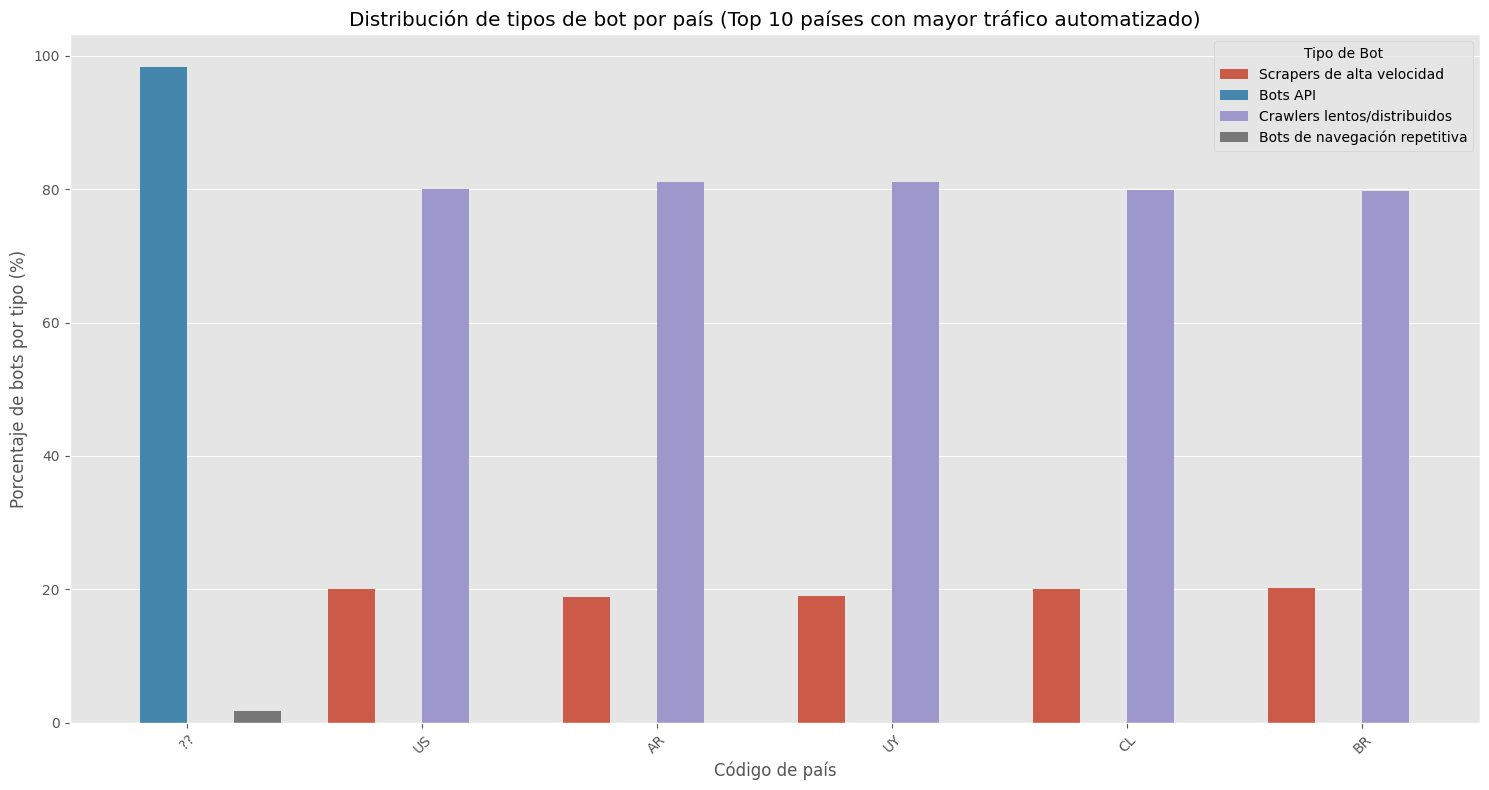

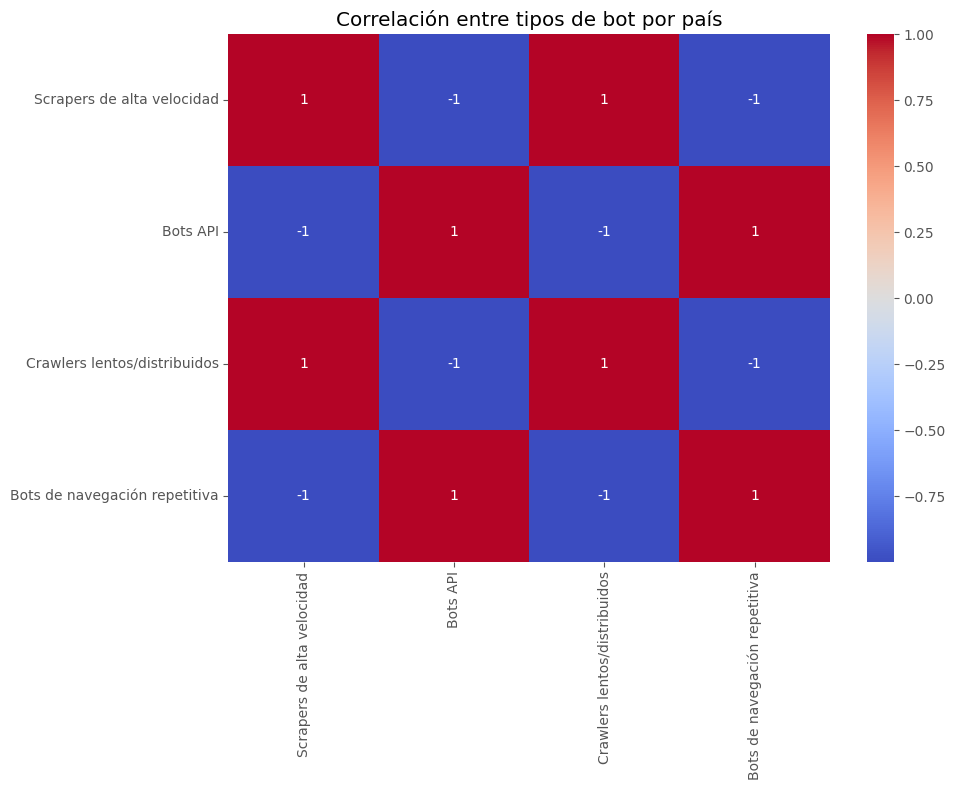


IPs CON MAYOR ACTIVIDAD SOSPECHOSA

IPs con mayor número de sesiones de bot (min 5 sesiones):
192.168.0.102 (??): 172 sesiones de bot (100.0%)
192.168.0.187 (??): 170 sesiones de bot (100.0%)
192.168.0.229 (??): 168 sesiones de bot (100.0%)
192.168.0.83 (??): 166 sesiones de bot (100.0%)
192.168.0.12 (??): 165 sesiones de bot (99.4%)
192.168.0.132 (??): 164 sesiones de bot (100.0%)
192.168.0.28 (??): 163 sesiones de bot (99.4%)
192.168.0.219 (??): 162 sesiones de bot (99.4%)
192.168.0.43 (??): 162 sesiones de bot (99.4%)
192.168.0.92 (??): 162 sesiones de bot (100.0%)

Detalle de la IP con más actividad sospechosa (192.168.0.102):
Total de sesiones: 172
Sesiones de bot: 172

Distribución por tipo de bot:
  Scrapers de alta velocidad: 0 (0.0%)
  Bots API: 170 (98.8%)
  Crawlers lentos/distribuidos: 0 (0.0%)
  Bots de navegación repetitiva: 2 (1.2%)

User-Agents utilizados (4):
  1. curl/7.68.0
  2. Scrapy/2.5.0 (+https://scrapy.org)
  3. python-requests/2.25.1
  4. Go-http-client/1.1


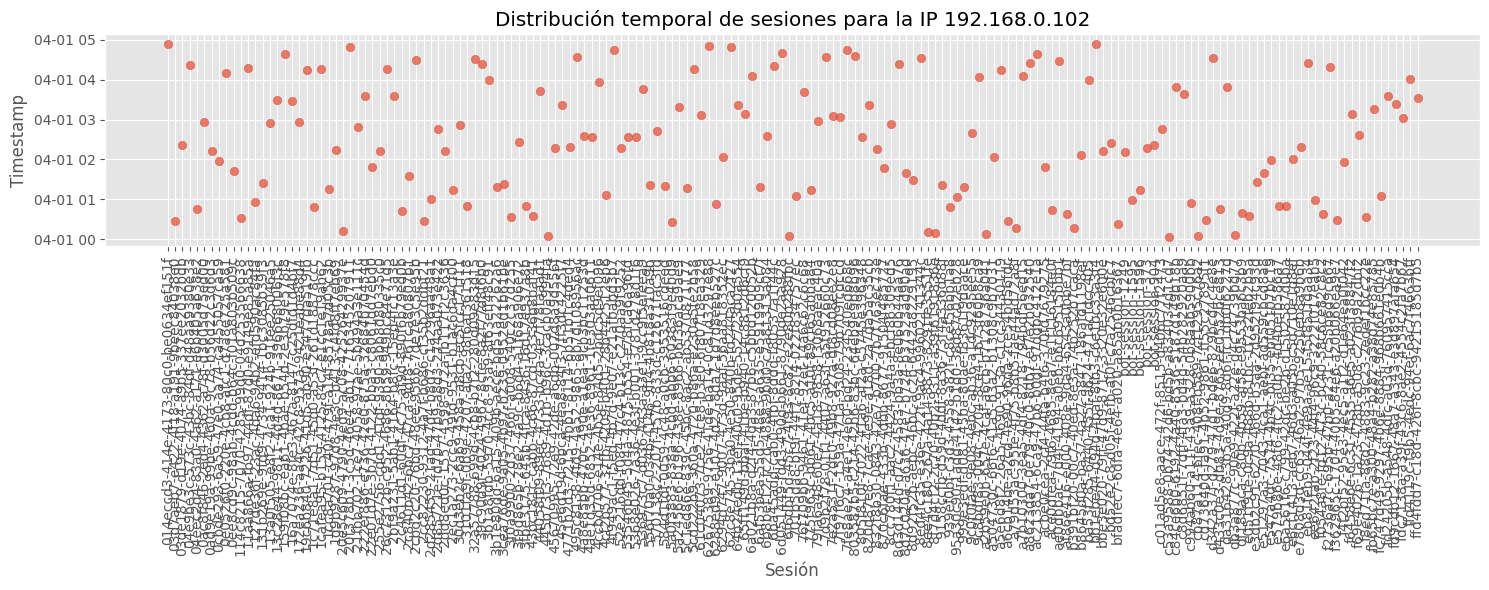


RECOMENDACIONES BASADAS EN EL ANÁLISIS

Basado en el análisis detallado de tráfico sospechoso, se recomienda:

1. Implementar alertas específicas para los tipos de bot más prevalentes en tu sistema:
   - Monitorear especialmente IPs con alta concentración de actividad sospechosa
   - Establecer umbrales de alerta por tipo de bot

2. Aplicar medidas de mitigación diferenciadas por tipo de bot:
   - Scrapers de alta velocidad: Implementar rate limiting adaptativo
   - Bots API: Requerir autenticación API y tokens para endpoints críticos
   - Crawlers lentos: Implementar desafíos progresivos (CAPTCHA, etc.)
   - Bots repetitivos: Bloquear patrones de navegación con alta uniformidad

3. Considerar geolocalización en estrategias de mitigación:
   - Evaluar implementar verificaciones adicionales para tráfico de países con alta proporción de bots
   - Monitorear cambios en patrones de origen geográfico de bots

4. Refinar las reglas de detección basadas en los casos analizados:
   - Utilizar

In [ ]:
# Código mejorado para identificación de tráfico sospechoso por tipo de bot
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import timedelta

# 1. IDENTIFICACIÓN DE SESIONES SOSPECHOSAS POR TIPO DE BOT
print("=" * 50)
print("IDENTIFICACIÓN DE TRÁFICO SOSPECHOSO POR TIPO DE BOT")
print("=" * 50)

# Definir las etiquetas de los clusters
bot_types = {
    0: "Scrapers de alta velocidad",
    1: "Bots API",
    2: "Crawlers lentos/distribuidos",
    3: "Bots de navegación repetitiva"
}

# Asegurarse de que tenemos la probabilidad del XGBoost en features_df
if 'xgb_prob' not in features_df.columns and 'xgb_prob_cv' in features_df.columns:
    features_df['xgb_prob'] = features_df['xgb_prob_cv']

# Combinar información de clustering con features_df
# Creamos un diccionario de mapeo de session_id a cluster
cluster_mapping = {}
for session_id, cluster in zip(bot_profiles.index, bot_profiles['cluster']):
    cluster_mapping[session_id] = cluster

# Añadir cluster a features_df solo para sesiones identificadas como bots
features_with_cluster = features_df.copy()
features_with_cluster['bot_cluster'] = np.nan

# Aplicar el mapeo de cluster
for session_id in features_with_cluster.index:
    if session_id in cluster_mapping:
        features_with_cluster.loc[session_id, 'bot_cluster'] = cluster_mapping[session_id]

# Filtrar solo sesiones identificadas como bots (basado en tu umbral final)
# Asumiendo que 'is_bot_final' es la columna con la clasificación final
bot_sessions = features_with_cluster[features_with_cluster['is_bot_final'] == 1]

# 2. TOP SESIONES SOSPECHOSAS POR CADA TIPO DE BOT
print("\nTop sesiones sospechosas por tipo de bot:")

# Columnas clave para mostrar por cada tipo de bot
common_cols = ['xgb_prob', 'requests_per_second', 'interval_uniformity',
               'unique_urls', 'repetitive_patterns']

# Columnas específicas por tipo de bot
bot_specific_cols = {
    0: ['has_browser', 'is_business_hour', 'has_platform'],  # Scrapers de alta velocidad
    1: ['url_entropy', 'page_req_ratio', 'has_browser', 'param_count'],  # Bots API
    2: ['param_count', 'has_query_params', 'search_req_ratio', 'page_req_ratio'],  # Crawlers
    3: ['url_entropy', 'interval_uniformity', 'bytes_cv']  # Bots repetitivos
}

# Para cada tipo de bot, mostrar las 3 sesiones más sospechosas
for cluster_id, cluster_name in bot_types.items():
    # Filtrar sesiones de este tipo de bot
    cluster_sessions = bot_sessions[bot_sessions['bot_cluster'] == cluster_id]

    if len(cluster_sessions) == 0:
        print(f"\nNo hay sesiones del tipo {cluster_name} (Cluster {cluster_id})")
        continue

    # Ordenar por probabilidad para encontrar las más sospechosas
    top_sessions = cluster_sessions.sort_values('xgb_prob', ascending=False).head(3)

    print(f"\n--- Top 3 sesiones del tipo {cluster_name} (Cluster {cluster_id}) ---")

    # Definir columnas a mostrar (comunes + específicas)
    display_cols = common_cols.copy()
    if cluster_id in bot_specific_cols:
        # Añadir solo las columnas específicas que existen en el DataFrame
        specific_cols = [col for col in bot_specific_cols[cluster_id] if col in cluster_sessions.columns]
        display_cols.extend(specific_cols)

    # Mostrar información relevante
    for i, (session_id, session) in enumerate(top_sessions.iterrows()):
        print(f"\nSesión #{i+1} (ID: {session_id}, Prob: {session['xgb_prob']:.4f})")

        # Mostrar características clave para este tipo de bot
        for col in display_cols:
            if col in session:
                value = session[col]
                print(f"  {col}: {value}")

        # Extraer detalles específicos de esta sesión
        if session_id in df['session_id'].values:
            session_details = df[df['session_id'] == session_id].sort_values('timestamp')

            # Mostrar número de requests y duración
            if len(session_details) > 0:
                start_time = pd.to_datetime(session_details['timestamp'].iloc[0])
                end_time = pd.to_datetime(session_details['timestamp'].iloc[-1])
                duration = (end_time - start_time).total_seconds()

                print(f"  Número de requests: {len(session_details)}")
                print(f"  Duración: {duration:.2f} segundos")
                print(f"  User-Agent: {session_details['user_agent'].iloc[0][:100]}...")

                # Mostrar los primeros N paths de URL
                print("  Primeras URLs visitadas:")
                for j, url in enumerate(session_details['url_path'].head(5)):
                    print(f"    {j+1}. {url}")

                if len(session_details) > 5:
                    print(f"    ... y {len(session_details)-5} más")

# Corrección para evitar división por cero en el análisis detallado
print("\n" + "=" * 50)
print(f"ANÁLISIS DETALLADO DE LA SESIÓN MÁS SOSPECHOSA")
print("=" * 50)
print(f"ID de sesión: {most_suspicious_id}")
print(f"Tipo de bot: {bot_types.get(most_suspicious_cluster, 'Desconocido')}")
print(f"Probabilidad: {most_suspicious['xgb_prob']:.4f}")

# Extraer detalles de esta sesión
session_details = df[df['session_id'] == most_suspicious_id].sort_values('timestamp')

if len(session_details) > 0:
    # Información general
    print("\nInformación general:")
    print(f"Número total de requests: {len(session_details)}")
    print(f"IP: {session_details['ip_address'].iloc[0]}")
    print(f"País: {session_details['country_code'].iloc[0]}")
    print(f"User-Agent: {session_details['user_agent'].iloc[0]}")

    # Análisis temporal
    start_time = pd.to_datetime(session_details['timestamp'].iloc[0])
    end_time = pd.to_datetime(session_details['timestamp'].iloc[-1])
    duration = (end_time - start_time).total_seconds()

    print(f"\nAnálisis temporal:")
    print(f"Hora de inicio: {start_time}")
    print(f"Hora de fin: {end_time}")
    print(f"Duración total: {duration:.2f} segundos")

    # Calcular requests por segundo evitando división por cero
    if duration > 0:
        print(f"Requests por segundo: {len(session_details)/duration:.2f}")
    else:
        print(f"Requests por segundo: INFINITO (todas las requests en el mismo segundo)")
        # Si la duración es 0, asignamos un valor pequeño para cálculos posteriores
        duration = 0.001  # 1 milisegundo para evitar división por cero

    # Calcular diferencias de tiempo entre requests
    session_times = pd.to_datetime(session_details['timestamp'])
    if len(session_times) > 1:
        time_diffs = []
        for i in range(1, len(session_times)):
            diff = (session_times.iloc[i] - session_times.iloc[i-1]).total_seconds()
            # Si la diferencia es 0, asignar un valor muy pequeño para evitar problemas
            time_diffs.append(diff if diff > 0 else 0.001)

        # Verificar si hay valores en time_diffs antes de calcular estadísticas
        if time_diffs:
            print(f"Intervalo medio entre requests: {np.mean(time_diffs):.4f} segundos")
            print(f"Desviación estándar de intervalos: {np.std(time_diffs):.4f} segundos")

            # Evitar división por cero en coeficiente de variación
            mean_diff = np.mean(time_diffs)
            if mean_diff > 0:
                print(f"CV de intervalos: {np.std(time_diffs)/mean_diff:.4f}")
            else:
                print("CV de intervalos: INFINITO (intervalos extremadamente uniformes)")

            # Visualizar distribución de intervalos entre requests
            plt.figure(figsize=(12, 6))
            plt.subplot(2, 1, 1)
            plt.plot(range(1, len(time_diffs) + 1), time_diffs, 'o-')
            plt.axhline(np.mean(time_diffs), color='red', linestyle='--',
                       label=f'Intervalo medio: {np.mean(time_diffs):.4f}s')
            plt.title(f'Intervalos entre solicitudes para la sesión {most_suspicious_id}')
            plt.xlabel('Número de solicitud')
            plt.ylabel('Intervalo (segundos)')
            plt.legend()
            plt.grid(True)

            # Histograma de intervalos
            plt.subplot(2, 1, 2)
            plt.hist(time_diffs, bins=20, alpha=0.7)
            plt.axvline(np.mean(time_diffs), color='red', linestyle='--',
                       label=f'Media: {np.mean(time_diffs):.4f}s')
            plt.title('Distribución de intervalos entre solicitudes')
            plt.xlabel('Intervalo (segundos)')
            plt.ylabel('Frecuencia')
            plt.legend()
            plt.grid(True)
            plt.tight_layout()
            plt.show()
        else:
            print("No se pueden calcular estadísticas de intervalos: todas las solicitudes tienen el mismo timestamp")
    else:
        print("Solo hay una solicitud en esta sesión, no se pueden calcular intervalos")

# 4. ANÁLISIS DE TRÁFICO SOSPECHOSO POR PAÍS
print("\n" + "=" * 50)
print("ANÁLISIS DE TRÁFICO SOSPECHOSO POR PAÍS")
print("=" * 50)

# Obtener estadísticas por país
country_stats = df.groupby('country_code')['session_id'].nunique().reset_index()
country_stats.columns = ['country_code', 'session_count']

# Calcular ratio de bots por país
country_bot_counts = {}
country_bot_types = {}

for country in country_stats['country_code']:
    # Obtener todas las sesiones de este país
    country_sessions = df[df['country_code'] == country]['session_id'].unique()

    # Contar cuántas son bots
    bot_count = 0
    bot_by_type = {0: 0, 1: 0, 2: 0, 3: 0}

    for s in country_sessions:
        if s in features_df.index and features_df.loc[s, 'is_bot_final'] == 1:
            bot_count += 1

            # Contar por tipo si tenemos la información
            if s in cluster_mapping:
                cluster = cluster_mapping[s]
                bot_by_type[cluster] = bot_by_type.get(cluster, 0) + 1

    # Guardar ratio
    country_bot_counts[country] = bot_count / len(country_sessions) if len(country_sessions) > 0 else 0
    country_bot_types[country] = bot_by_type

# Añadir info al DataFrame
country_stats['bot_ratio'] = country_stats['country_code'].map(country_bot_counts)

# Añadir conteo por tipo de bot
for cluster_id, cluster_name in bot_types.items():
    country_stats[f'bot_type_{cluster_id}'] = country_stats['country_code'].apply(
        lambda c: country_bot_types.get(c, {}).get(cluster_id, 0)
    )
    country_stats[f'bot_type_{cluster_id}_ratio'] = country_stats[f'bot_type_{cluster_id}'] / country_stats['session_count']

# Filtrar para países con suficientes sesiones
min_sessions = 10
country_stats_filtered = country_stats[country_stats['session_count'] >= min_sessions]

# Mostrar países con mayor proporción de bots
top_bot_countries = country_stats_filtered.sort_values('bot_ratio', ascending=False).head(15)

print(f"\nPaíses con mayor proporción de tráfico automatizado (min {min_sessions} sesiones):")
for _, row in top_bot_countries.iterrows():
    print(f"{row['country_code']}: {row['bot_ratio']*100:.1f}% de bots ({row['session_count']} sesiones)")

# Visualizar distribución de tipos de bot por país (top 10 países)
plt.figure(figsize=(15, 8))

# Preparar datos para el gráfico
top_countries = top_bot_countries['country_code'].head(10).tolist()
bot_type_data = []

for country in top_countries:
    country_row = country_stats[country_stats['country_code'] == country].iloc[0]
    total_bots = sum(country_bot_types.get(country, {}).values())

    for cluster_id, cluster_name in bot_types.items():
        type_count = country_bot_types.get(country, {}).get(cluster_id, 0)
        percent = type_count / total_bots * 100 if total_bots > 0 else 0

        bot_type_data.append({
            'country': country,
            'bot_type': cluster_name,
            'percentage': percent
        })

# Crear DataFrame para visualización
bot_type_df = pd.DataFrame(bot_type_data)

# Gráfico de distribución de tipos de bot por país
plt.figure(figsize=(15, 8))
sns.barplot(x='country', y='percentage', hue='bot_type', data=bot_type_df)
plt.title('Distribución de tipos de bot por país (Top 10 países con mayor tráfico automatizado)')
plt.xlabel('Código de país')
plt.ylabel('Porcentaje de bots por tipo (%)')
plt.xticks(rotation=45)
plt.legend(title='Tipo de Bot')
plt.tight_layout()
plt.show()

# Mapa de calor de correlación entre tipos de bot por país
correlation_cols = [f'bot_type_{i}_ratio' for i in range(4)]
correlation_matrix = country_stats_filtered[correlation_cols].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm',
            xticklabels=[bot_types[i] for i in range(4)],
            yticklabels=[bot_types[i] for i in range(4)])
plt.title('Correlación entre tipos de bot por país')
plt.tight_layout()
plt.show()

# 5. IP CON MAYOR ACTIVIDAD SOSPECHOSA
print("\n" + "=" * 50)
print("IPs CON MAYOR ACTIVIDAD SOSPECHOSA")
print("=" * 50)

# Agrupar por IP y contar sesiones
ip_stats = df.groupby('ip_address')['session_id'].nunique().reset_index()
ip_stats.columns = ['ip_address', 'session_count']

# Calcular cuántas sesiones son bots para cada IP
ip_bot_counts = {}
ip_bot_types = {}

for ip in ip_stats['ip_address']:
    # Obtener todas las sesiones de esta IP
    ip_sessions = df[df['ip_address'] == ip]['session_id'].unique()

    # Contar cuántas son bots
    bot_count = 0
    bot_by_type = {0: 0, 1: 0, 2: 0, 3: 0}

    for s in ip_sessions:
        if s in features_df.index and features_df.loc[s, 'is_bot_final'] == 1:
            bot_count += 1

            # Contar por tipo si tenemos la información
            if s in cluster_mapping:
                cluster = cluster_mapping[s]
                bot_by_type[cluster] = bot_by_type.get(cluster, 0) + 1

    # Guardar conteo
    ip_bot_counts[ip] = bot_count
    ip_bot_types[ip] = bot_by_type

# Añadir conteos al DataFrame
ip_stats['bot_count'] = ip_stats['ip_address'].map(ip_bot_counts)
ip_stats['bot_ratio'] = ip_stats['bot_count'] / ip_stats['session_count']

# Añadir país de cada IP
ip_country = df.groupby('ip_address')['country_code'].first().to_dict()
ip_stats['country'] = ip_stats['ip_address'].map(ip_country)

# Top IPs con mayor actividad sospechosa (filtrar por mínimo de sesiones)
min_ip_sessions = 5
ip_stats_filtered = ip_stats[ip_stats['session_count'] >= min_ip_sessions]
top_bot_ips = ip_stats_filtered.sort_values('bot_count', ascending=False).head(10)

print(f"\nIPs con mayor número de sesiones de bot (min {min_ip_sessions} sesiones):")
for _, row in top_bot_ips.iterrows():
    print(f"{row['ip_address']} ({row['country']}): {row['bot_count']} sesiones de bot ({row['bot_ratio']*100:.1f}%)")

# Mostrar detalles de la IP con más actividad sospechosa
if len(top_bot_ips) > 0:
    most_active_ip = top_bot_ips.iloc[0]['ip_address']
    ip_sessions = df[df['ip_address'] == most_active_ip]['session_id'].unique()

    print(f"\nDetalle de la IP con más actividad sospechosa ({most_active_ip}):")
    print(f"Total de sesiones: {len(ip_sessions)}")
    print(f"Sesiones de bot: {ip_bot_counts.get(most_active_ip, 0)}")

    # Mostrar distribución por tipo de bot
    print("\nDistribución por tipo de bot:")
    for cluster_id, cluster_name in bot_types.items():
        count = ip_bot_types.get(most_active_ip, {}).get(cluster_id, 0)
        total = ip_bot_counts.get(most_active_ip, 0)
        percentage = count / total * 100 if total > 0 else 0
        print(f"  {cluster_name}: {count} ({percentage:.1f}%)")

    # Mostrar User-Agents utilizados por esta IP
    ip_user_agents = df[df['ip_address'] == most_active_ip]['user_agent'].unique()
    print(f"\nUser-Agents utilizados ({len(ip_user_agents)}):")
    for i, ua in enumerate(ip_user_agents[:5]):  # Mostrar solo los primeros 5
        print(f"  {i+1}. {ua}")

    if len(ip_user_agents) > 5:
        print(f"  ... y {len(ip_user_agents)-5} más")

    # Visualizar la actividad temporal de esta IP
    ip_activity = df[df['ip_address'] == most_active_ip].copy()
    ip_activity['timestamp'] = pd.to_datetime(ip_activity['timestamp'])
    ip_activity = ip_activity.sort_values('timestamp')

    # Agrupar por sesión y calcular tiempos
    session_start_times = ip_activity.groupby('session_id')['timestamp'].min()

    # Visualizar distribución temporal de sesiones
    plt.figure(figsize=(15, 6))
    plt.scatter(session_start_times.index, session_start_times, alpha=0.7)
    plt.title(f'Distribución temporal de sesiones para la IP {most_active_ip}')
    plt.xlabel('Sesión')
    plt.ylabel('Timestamp')
    plt.grid(True)
    plt.xticks(rotation=90)
    plt.tight_layout()
    plt.show()

# 6. RECOMENDACIONES BASADAS EN EL ANÁLISIS


#RECOMENDACIONES BASADAS EN EL ANÁLISIS

#Basado en el análisis detallado de tráfico sospechoso, se recomienda:

#1. Implementar alertas específicas para los tipos de bot más prevalentes en el sistema:
   - Monitorear especialmente IPs con alta concentración de actividad sospechosa
   - Establecer umbrales de alerta por tipo de bot

#2. Aplicar medidas de mitigación diferenciadas por tipo de bot:
   - Scrapers de alta velocidad: Implementar rate limiting adaptativo
   - Bots API: Requerir autenticación API y tokens para endpoints críticos
   - Crawlers lentos: Implementar desafíos progresivos (CAPTCHA, etc.)
   - Bots repetitivos: Bloquear patrones de navegación con alta uniformidad

#3. Considerar geolocalización en estrategias de mitigación:
   - Evaluar implementar verificaciones adicionales para tráfico de países con alta proporción de bots
   - Monitorear cambios en patrones de origen geográfico de bots

#4. Refinar las reglas de detección basadas en los casos analizados:
   - Utilizar los patrones observados en las sesiones más sospechosas para mejorar reglas
   - Considerar umbrales específicos por tipo de bot según el análisis realizado)

Patrones específicos identificados para investigación adicional:
##1. User-Agents sospechosos detectados
##2. Patrones temporales altamente regulares
##3. Secuencias de navegación no naturales
##4. IPs con múltiples sesiones bot de diferentes tipos

#6. Aplicación de GenAI en la detección de tráfico web anómalo

#Propuesta: Sistema de detección de bots asistido por LLMs
##Propongo implementar un sistema híbrido que combine los modelos tradicionales de machine learning con modelos generativos (LLMs) para mejorar significativamente la detección de tráfico anómalo en Mercado Libre.
#Idea principal
##Los LLMs pueden complementar los sistemas tradicionales de detección de anomalías en tres áreas clave:

#Análisis semántico de patrones complejos
#Explicabilidad y contextualización de alertas
#Generación de reglas adaptativas

##Problema a resolver
Los sistemas tradicionales de detección de bots tienen limitaciones importantes:

###Falsos positivos: Frecuentemente confunden comportamientos legítimos pero inusuales con ataques automatizados.
###Falta de explicabilidad: No proporcionan contexto sobre por qué una sesión fue clasificada como bot.
###Adaptación lenta: Los equipos de seguridad tardan en actualizar las reglas frente a nuevas técnicas de ataque.

##Dificultad para detectar patrones complejos: Especialmente aquellos que imitan comportamiento humano.

###Implementación propuesta
#1. Análisis semántico de User-Agents y patrones de URL
#Los LLMs pueden analizar semánticamente User-Agents y secuencias de URLs para detectar patrones sospechosos que las reglas tradicionales o modelos estadísticos podrían perder.

In [ ]:
def analyze_with_llm(session_data):
    """
    Analiza una sesión web utilizando un LLM para detectar patrones anómalos
    """
    # Preparar los datos para el LLM
    user_agents = session_data['user_agent'].unique().tolist()
    url_sequence = session_data['url_path'].tolist()

    # Crear el prompt para el LLM
    prompt = f"""
    Analiza los siguientes datos de una sesión web y determina si pertenece a un bot o a un humano.

    User-Agents utilizados: {user_agents}

    Secuencia de URLs visitadas (las 20 primeras): {url_sequence[:20]}

    Intervalos entre peticiones (segundos): {session_data['time_diff'].tolist()[:20]}

    Basado en estos datos, ¿hay indicios de que esta sesión corresponda a un bot?
    Si es así, ¿qué tipo de bot podría ser y qué patrones lo evidencian?
    Proporciona tu análisis en formato JSON con los siguientes campos:
    - is_bot: true/false
    - confidence: valor de 0 a 1
    - bot_type: tipo de bot si aplica
    - evidence: lista de indicios que respaldan tu clasificación
    """

    # Llamar al LLM
    llm_response = call_llm_api(prompt)

    # Parsear la respuesta y retornar
    return parse_llm_response(llm_response)

#2. Sistema de explicabilidad para alertas
Implementar un componente que utilice LLMs para generar explicaciones en lenguaje natural sobre las detecciones, facilitando la revisión por parte del equipo de seguridad.

In [ ]:
def generate_alert_explanation(session_features, model_prediction, threshold=0.8):
    """
    Genera una explicación detallada de por qué una sesión fue clasificada como bot
    """
    if model_prediction < threshold:
        return None

    # Identificar las características más importantes que llevaron a la clasificación
    feature_importances = get_feature_importances(session_features)
    top_features = sorted(feature_importances.items(), key=lambda x: x[1], reverse=True)[:5]

    # Crear el prompt para el LLM
    prompt = f"""
    Una sesión web ha sido clasificada como bot con una probabilidad de {model_prediction:.2f}.

    Las características más importantes que llevaron a esta clasificación son:
    {top_features}

    Genera una explicación clara y concisa sobre por qué esta sesión parece ser un bot,
    mencionando específicamente estas características y qué indican sobre el comportamiento.
    La explicación debe ser comprensible para personal de seguridad no técnico.
    Incluye también posibles casos de uso legítimo que podrían generar comportamientos similares,
    para ayudar a evaluar si podría tratarse de un falso positivo.
    """

    # Llamar al LLM y retornar la explicación
    return call_llm_api(prompt)

#3. Generación de reglas adaptativas
Utilizar LLMs para analizar patrones emergentes y proponer nuevas reglas de detección que puedan ser revisadas e implementadas por el equipo de seguridad.

In [ ]:
def generate_adaptive_rules(recent_bot_sessions):
    """
    Analiza sesiones recientes clasificadas como bot y propone nuevas reglas
    """
    # Extraer características de las sesiones recientes
    session_stats = extract_session_statistics(recent_bot_sessions)

    # Crear el prompt para el LLM
    prompt = f"""
    Analiza las siguientes estadísticas de sesiones web recientes clasificadas como bots:

    {session_stats}

    Basado en estos datos, propón 3-5 nuevas reglas de detección específicas que puedan
    ayudar a identificar este tipo de tráfico automatizado. Las reglas deben:

    1. Ser específicas y cuantificables
    2. Minimizar los falsos positivos
    3. Ser implementables como condiciones lógicas

    Para cada regla, proporciona:
    - La condición específica
    - Los umbrales recomendados
    - Una explicación de por qué esta regla sería efectiva
    - Posibles escenarios de falsos positivos a considerar

    Devuelve las reglas en formato JSON.
    """

    # Llamar al LLM
    llm_response = call_llm_api(prompt)

    # Parsear la respuesta y retornar las reglas
    return parse_rules_from_llm(llm_response)

#Beneficios de la implementación

##Reducción de falsos positivos:
Los LLMs pueden interpretar contextos complejos para distinguir mejor entre comportamientos humanos inusuales y bots.
##Mayor explicabilidad:
Proporcionan justificaciones en lenguaje natural que facilitan la comprensión y validación por parte del equipo de seguridad.
##Adaptación continua:
Ayudan a identificar y responder más rápidamente a nuevas técnicas de ataque mediante la generación de reglas actualizadas.
##Detección de comportamientos sofisticados:
Permiten identificar patrones sutiles que imitan comportamiento humano pero que tienen inconsistencias semánticas.
##Reducción de carga operativa:
Automatizan el análisis detallado de sesiones sospechosas, permitiendo al equipo enfocarse en casos prioritarios.

